Authors: José Raúl Romero (jrromero@uco.es), Aurora Ramírez (aurora.ramirez@uma.es), Francisco Javier Alcaide (f52almef@uco.es)

**Notebook for dummies model detection problem in the UML dataset**

Algorithms used: SVC, RF and KNN

For local explainability, we have considered the 10 features with the highest contribution in each technique. The features in the TOP 5 for the calculation of the coincidence metrics between explainability techniques.

# Installation:

It is important to define the path to the folder that contains the Modelset files, in this notebook using the variable "MODELSET_HOME".

In [ ]:
MODELSET_HOME="/content/drive/MyDrive/modelset"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install modelset-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=17f8ded2ff2b26bb9ee6190ddc9a64ca6fcfe1eed54ef686e9498e5f5972814d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2


In [ ]:
!pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042470 sha256=898d1dd4bb5305eaa14c7003b1e09075fd67664a883b587b29554751d4c45313
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=4ce3a02ff061611146fbaed6f1dd122ef56b429c03a9b84808b0c2a3d8270698
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import sys
import re
import pickle
import plotly
import kaleido
import pandas as pd
import numpy as np
import dalex as dx
import os
import modelset.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.inspection import permutation_importance

## Functions:

In [ ]:
# Function to evaluate the sign of values
def evaluate_value(value):
    if value >= 0:
        return "Positive"
    else:
        return "Negative"

In [ ]:
# Create the MultiIndex columns
columns_multi = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Sign'),
    ('Shap', 'Ranking'), ('Shap', 'Sign'),
    ('Lime', 'Ranking'), ('Lime', 'Sign')
])

In [ ]:
# Function to evaluate the top 5 features
def top5_features(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = set(df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])].index)
        set_expl[tech] = inst_top5

    result_case = {
        f'TOP5 {tech}': ', '.join(set_expl[tech]) for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'
                result_case[col_name] = len(inst_top5_1.intersection(inst_top5_2)) / 5

    df_top5_case = pd.DataFrame(result_case, index=[case])

    return df_top5_case

In [ ]:
# Function to evaluate the top 5 ranking
def top5_rank(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{ranking}:{inst}' for ranking, inst in zip(inst_top5[(tech, 'Ranking')], inst_top5.index)])

        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ') and inst.split(':')[1] == inst.split(':')[1]]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 5

    df_top5_rank = pd.DataFrame(result_case, index=[case])

    return df_top5_rank

In [ ]:
# Function to evaluate the top 5 sign
def top5_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{inst}:{sign}' for inst, sign in zip(inst_top5.index, inst_top5[(tech, 'Sign')])])

        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ')]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 5

    df_top5_sign = pd.DataFrame(result_case, index=[case])

    return df_top5_sign

In [ ]:
# Function to evaluate the top 5 sign and ranking
def top5_rank_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top5 = df[df[(tech, 'Ranking')].isin([1, 2, 3, 4, 5])]
        inst_top5_str = ', '.join([f'{ranking}:{inst}:{sign}' for ranking, inst, sign in zip(inst_top5[(tech, 'Ranking')], inst_top5.index, inst_top5[(tech, 'Sign')])])
        set_expl[tech] = inst_top5_str

    result_case = {
        f'TOP5 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top5_1 in set_expl.items():
        for tech2, inst_top5_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top5_1.split(', ') if inst in inst_top5_2.split(', ') and inst.split(':')[1] == inst.split(':')[1] and inst.split(':')[2] == inst.split(':')[2]]
                num_coincidence = len(coincidence)
                result_case[col_name] = num_coincidence / 5

    df_top5_rank_sign = pd.DataFrame(result_case, index=[case])

    return df_top5_rank_sign

In [ ]:
# Function to obtain the dataframes of the tech Breakdown, SHAP, and LIME.
def preprocess_dfs(breakdown_df, shap_df, lime_df, n, m):

    pattern = re.compile(r'(?:<=|<|>=|>)\s*(\w+)\s*(?:<=|<|>=|>)')

    breakdown_df = breakdown_df.loc[:, ['variable_name', 'contribution', 'sign']]
    breakdown_df = breakdown_df.drop(index=[0, n+1])
    breakdown_df['sign'] = breakdown_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    breakdown_df = breakdown_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    shap_df = shap_df.loc[:, ['variable_name', 'contribution', 'sign']]
    shap_df = shap_df.tail(n)
    shap_df['sign'] = shap_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    shap_df = shap_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    lime_list = []
    for feature in lime_df['variable']:
      if pattern.findall(feature):
        match = pattern.search(feature)
        if match:
          lime_list.append(match.group(1))
      else:
        splits = feature.split(" ")
        lime_list.append(splits[0])

    lime_df["Feature"] = lime_list
    lime_df["Sign"] = lime_df["effect"].apply(evaluate_value)
    lime_df = lime_df.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
    lime_df = lime_df.drop(columns=['variable'])

    breakdown_df['Ranking'] = breakdown_df['contribution'].abs().rank(ascending=False).astype(int)
    breakdown_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    breakdown_df = breakdown_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    shap_df['Ranking'] = shap_df['contribution'].abs().rank(ascending=False).astype(int)
    shap_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    shap_df = shap_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    lime_df['Ranking'] = lime_df['effect'].abs().rank(ascending=False).astype(int)
    lime_df = lime_df.head(m)
    lime_df = lime_df[['Feature', 'Ranking', 'effect', 'Sign']]

    breakdown_df = breakdown_df.drop(columns=['contribution'])
    shap_df = shap_df.drop(columns=['contribution'])
    lime_df = lime_df.drop(columns=['effect'])

    breakdown_df = breakdown_df.head(m)
    breakdown_df = breakdown_df.reset_index(drop=True)

    shap_df= shap_df.head(m)
    shap_df = shap_df.reset_index(drop=True)

    lime_df = lime_df.reset_index(drop=True)

    breakdown_features = list(breakdown_df['Feature'])
    shap_features = list(shap_df['Feature'])
    lime_features = list(lime_df['Feature'])
    all_features = list(set(breakdown_features + shap_features + lime_features))
    all_features = all_features[::-1]

    df_final = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
    df_final['Feature'] = list(all_features)
    df_final = df_final[['Feature', 'Breakdown', 'Shap', 'Lime']]

    #print(breakdown_features)
    #print(shap_features)
    #print(lime_features)
    print(all_features)

    for feature in df_final['Feature']:

        breakdown_row = breakdown_df[breakdown_df['Feature'] == feature]
        if not breakdown_row.empty:

            ranking_breakdown = breakdown_row.iloc[0]['Ranking']
            sign_breakdown = breakdown_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = sign_breakdown
        else:

            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


        shap_row = shap_df[shap_df['Feature'] == feature]
        if not shap_row.empty:
            ranking_shap = shap_row.iloc[0]['Ranking']
            sign_shap = shap_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = sign_shap
        else:
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = '-'


        lime_row = lime_df[lime_df['Feature'] == feature]
        if not lime_row.empty:
            ranking_lime = lime_row.iloc[0]['Ranking']
            sign_lime = lime_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = sign_lime
        else:
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = '-'


    ranking_breakdown = df_final[('Breakdown', 'Ranking')]
    values_valid = ranking_breakdown[ranking_breakdown != '-']
    cases_invalid = ranking_breakdown[ranking_breakdown == '-'].index
    cases_valid = []
    cases_invalid_restantes = list(cases_invalid)
    cases_valid.extend(values_valid.sort_values().index.tolist())

    for cas in cases_invalid:
        value_shap = df_final.at[cas, ('Shap', 'Ranking')]
        if value_shap != '-':
            cases_valid.extend([cas])
            cases_invalid_restantes.remove(cas)

    for cas in cases_invalid_restantes:
        value_lime = df_final.at[cas, ('Lime', 'Ranking')]
        if value_lime != '-':
            cases_valid.extend([cas])

    df_final = df_final.loc[cases_valid]
    df_final.set_index('Feature', inplace=True)
    return breakdown_df, shap_df, lime_df, df_final


In [ ]:
# Function to create final dataframes with all the disagreement metrics and calculate the means of disagreement metrics for each pair of techniques.
def calculate_metrics(df_list):
    df_final = pd.concat(df_list)

    mean_bd_shap = df_final['Breakdown-Shap'].mean()
    mean_bd_lime = df_final['Breakdown-Lime'].mean()
    mean_lime_shap = df_final['Lime-Shap'].mean()

    return df_final, mean_bd_shap, mean_bd_lime, mean_lime_shap

In [ ]:
# Function to create dictionaries containing the disagreement metrics dataframes
def create_metrics_dfs(metrics_dict, metric_type):
    dfs = {'Model_comparison': {}, 'Class_comparison': {}}
    columns_model = ['Class', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    columns_class = ['Model', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    metric_names = [f'Mean_{metric_type}_BD_Shap', f'Mean_{metric_type}_BD_Lime', f'Mean_{metric_type}_Lime_Shap']

    for model_name, indexes_dict in metrics_dict.items():
        for index_name, metrics in indexes_dict.items():
            if model_name not in dfs['Class_comparison']:
                dfs['Class_comparison'][model_name] = pd.DataFrame(columns=columns_model)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            class_data = [index_name] + get_metrics
            dfs['Class_comparison'][model_name] = pd.concat([dfs['Class_comparison'][model_name], pd.Series(class_data, index=columns_model).to_frame().T], ignore_index=True)

            if index_name not in dfs['Model_comparison']:
                dfs['Model_comparison'][index_name] = pd.DataFrame(columns=columns_class)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            model_data = [model_name] + get_metrics
            dfs['Model_comparison'][index_name] = pd.concat([dfs['Model_comparison'][index_name], pd.Series(model_data, index=columns_class).to_frame().T], ignore_index=True)

    return dfs

In [ ]:
# Function to obtain dataframes of explanations, disagreement metrics, and each of the disagreement metrics dataframes
def calculate_metrics_for_indices(models_dict, indexes_dict, X_test, X_train, y_train, num_features, top_num_features):
    results_dict = {}
    metrics_dict = {}

    for model_name, model in models_dict.items():
        results_dict[model_name] = {}
        metrics_dict[model_name] = {}

        exp = dx.Explainer(model, X_train, y_train)

        for index_name, indices in indexes_dict.items():
          results_dict[model_name][index_name] = {}
          metrics_dict[model_name][index_name] = {}
          model_results = results_dict[model_name][index_name]
          df_list_top = []
          df_list_rank = []
          df_list_sign = []
          df_list_rank_sign = []

          for i in indices:
            instance = X_test.loc[i]

            breakdown = exp.predict_parts(instance, type="break_down", random_state=42)
            shap = exp.predict_parts(instance, type="shap", random_state=42)
            lime = exp.predict_surrogate(instance, random_state=42)
            breakdown_df = breakdown.result
            shap_df = shap.result
            lime_df = lime.result

            breakdown_df, shap_df, lime_df, df_final = preprocess_dfs(breakdown_df, shap_df, lime_df, num_features, top_num_features)

            model_results[f"breakdown_df_{i}"] = breakdown_df
            model_results[f"shap_df_{i}"] = shap_df
            model_results[f"lime_df_{i}"] = lime_df
            model_results[f"df_final_{i}"] = df_final

            metrics_dict[model_name][index_name][f"df_top_metric_{i}"] = top3_features(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            metrics_dict[model_name][index_name][f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            #model_results[f"df_top_metric_{i}"] = top3_features(df_final, i)
            #model_results[f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            #model_results[f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            #model_results[f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            df_list_top.append(metrics_dict[model_name][index_name][f'df_top_metric_{i}'])
            df_list_rank.append(metrics_dict[model_name][index_name][f'df_rank_metric_{i}'])
            df_list_sign.append(metrics_dict[model_name][index_name][f'df_sign_metric_{i}'])
            df_list_rank_sign.append(metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'])

          df_top_metric_final, mean_top_bd_shap, mean_top_bd_lime, mean_top_lime_shap = calculate_metrics(df_list_top)
          df_rank_metric_final, mean_rank_bd_shap, mean_rank_bd_lime, mean_rank_lime_shap = calculate_metrics(df_list_rank)
          df_sign_metric_final, mean_sign_bd_shap, mean_sign_bd_lime, mean_sign_lime_shap = calculate_metrics(df_list_sign)
          df_rank_sign_metric_final, mean_rank_sign_bd_shap, mean_rank_sign_bd_lime, mean_rank_sign_lime_shap = calculate_metrics(df_list_rank_sign)

          metrics_dict[model_name][index_name][f'Mean_top_BD_Shap'] = mean_top_bd_shap
          metrics_dict[model_name][index_name][f'Mean_top_BD_Lime'] = mean_top_bd_lime
          metrics_dict[model_name][index_name][f'Mean_top_Lime_Shap'] = mean_top_lime_shap
          metrics_dict[model_name][index_name][f'df_top_metric_final'] = df_top_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_BD_Shap'] = mean_rank_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_BD_Lime'] = mean_rank_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_Lime_Shap'] = mean_rank_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_metric_final'] = df_rank_metric_final

          metrics_dict[model_name][index_name][f'Mean_sign_BD_Shap'] = mean_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_sign_BD_Lime'] = mean_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_sign_Lime_Shap'] = mean_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_sign_metric_final'] = df_sign_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Shap'] = mean_rank_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Lime'] = mean_rank_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_sign_Lime_Shap'] = mean_rank_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_sign_metric_final'] = df_rank_sign_metric_final

    top_metric_df = create_metrics_dfs(metrics_dict, 'top')
    rank_metric_df = create_metrics_dfs(metrics_dict, 'rank')
    sign_metric_df = create_metrics_dfs(metrics_dict, 'sign')
    rank_sign_metric_df = create_metrics_dfs(metrics_dict, 'rank_sign')

    return metrics_dict, results_dict, top_metric_df, rank_metric_df, sign_metric_df, rank_sign_metric_df


# Load and Preprocess:

In this section, we will perform data loading, cleaning, preprocessing, and an initial data analysis.

In [ ]:
dataset = ds.load(MODELSET_HOME,modeltype = 'uml', selected_analysis = ['stats']) # load dataset
modelset_df = dataset._Dataset__to_df()

In [ ]:
duplicates = modelset_df.duplicated(subset='id', keep=False)
inst_dup = modelset_df[duplicates]
inst_dup

,id,category,tags,language,type_Generalization,type_Class,type_Interaction,type_Relationship,type_Package,type_Actor,...,type_UseCase,diagram_usecase,elements,type_Component,type_Enumeration,type_Association,type_Activity,diagram_comp,diagram_interaction,diagram_sm


In [ ]:
modelset_df

,id,category,tags,language,type_Generalization,type_Class,type_Interaction,type_Relationship,type_Package,type_Actor,...,type_UseCase,diagram_usecase,elements,type_Component,type_Enumeration,type_Association,type_Activity,diagram_comp,diagram_interaction,diagram_sm
0,repo-genmymodel-uml/data/_WJKFoOBcEeeAyLDAJ12_...,computer-ui,NaN,english,0,5,0,6,1,1,...,0,1.0,123,0,0,0,1,NaN,NaN,NaN
1,repo-genmymodel-uml/data/_grOBAOs7EeiJfugOH9Y5...,computer-videogames,videgame,english,0,8,0,3,1,0,...,0,NaN,56,0,1,0,0,NaN,NaN,NaN
2,repo-genmymodel-uml/data/_3e5Z4BBDEeqa8dopbpYH...,unknown,NaN,rusian,0,33,0,106,1,17,...,47,17.0,726,0,0,0,0,NaN,NaN,NaN
3,repo-genmymodel-uml/data/_zRSRMDEsEemjcq-iJCnV...,unknown,NaN,unknown,0,3,0,3,1,0,...,0,NaN,32,0,0,0,0,NaN,NaN,NaN
4,repo-genmymodel-uml/data/_1vnlQNqPEeiJYbNjsZ3w...,dummy,NaN,english,0,0,0,5,1,2,...,3,2.0,53,1,0,0,1,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,repo-genmymodel-uml/data/f60ea665-be9c-4b7d-b0...,shopping,NaN,english,0,8,0,20,1,3,...,4,3.0,270,0,2,0,1,NaN,NaN,NaN
5116,repo-genmymodel-uml/data/_XUNZYJuFEeexEbmG8xrw...,shopping,NaN,english,0,0,0,1,1,0,...,0,NaN,112,0,0,0,1,NaN,NaN,NaN
5117,repo-genmymodel-uml/data/1fd45148-722f-4b60-93...,realstate,real-state,english,0,13,0,15,1,0,...,0,NaN,202,0,0,0,0,NaN,NaN,NaN
5118,repo-genmymodel-uml/data/bc00e7fa-4d5b-4f96-8c...,computer-videogames,card-game,english,0,6,0,8,1,0,...,0,NaN,84,0,2,0,0,NaN,NaN,NaN


In [ ]:
modelset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5120 entries, 0 to 5119
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5120 non-null   object 
 1   category             5120 non-null   object 
 2   tags                 1943 non-null   object 
 3   language             5120 non-null   object 
 4   type_Generalization  5120 non-null   int64  
 5   type_Class           5120 non-null   int64  
 6   type_Interaction     5120 non-null   int64  
 7   type_Relationship    5120 non-null   int64  
 8   type_Package         5120 non-null   int64  
 9   type_Actor           5120 non-null   int64  
 10  diagram_ad           1542 non-null   float64
 11  type_DataType        5120 non-null   int64  
 12  diagram_cd           3110 non-null   float64
 13  type_Operation       5120 non-null   int64  
 14  type_Transition      5120 non-null   int64  
 15  type_State           5120 non-null   int64 

In [ ]:
# Reset index
modelset_df = modelset_df.reset_index(drop=True)

# Remove useless features
modelset_df = modelset_df.drop(['diagram_ad'], axis=1)
modelset_df = modelset_df.drop(['diagram_cd'], axis=1)
modelset_df = modelset_df.drop(['diagram_usecase'], axis=1)
modelset_df = modelset_df.drop(['diagram_comp'], axis=1)
modelset_df = modelset_df.drop(['diagram_interaction'], axis=1)
modelset_df = modelset_df.drop(['diagram_sm'], axis=1)
modelset_df = modelset_df.drop(['elements'], axis=1)
modelset_df = modelset_df.drop(['tags'], axis=1)
modelset_df = modelset_df.drop(['language'], axis=1)
modelset_df = modelset_df.drop(['id'], axis=1)

modelset_df_dummy = modelset_df.copy()

In [ ]:
modelset_df.head()

,category,type_Generalization,type_Class,type_Interaction,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Association,type_Activity
0,computer-ui,0,5,0,6,1,1,11,21,0,0,22,0,0,0,0,1
1,computer-videogames,0,8,0,3,1,0,7,6,0,0,20,0,0,1,0,0
2,unknown,0,33,0,106,1,17,1,0,0,0,203,47,0,0,0,0
3,unknown,0,3,0,3,1,0,2,0,0,0,15,0,0,0,0,0
4,dummy,0,0,0,5,1,2,0,0,0,0,4,3,1,0,0,1


In [ ]:
modelset_df.isnull().any()

category               False
type_Generalization    False
type_Class             False
type_Interaction       False
type_Relationship      False
type_Package           False
type_Actor             False
type_DataType          False
type_Operation         False
type_Transition        False
type_State             False
type_Property          False
type_UseCase           False
type_Component         False
type_Enumeration       False
type_Association       False
type_Activity          False
dtype: bool

In [ ]:
modelset_df['category'].value_counts()

shopping                695
dummy                   606
unknown                 445
restaurant              265
computer-videogames     242
                       ... 
productmanagement         1
collectionmanagement      1
machine-coffee            1
dashboard                 1
procedure-car             1
Name: category, Length: 127, dtype: int64

In [ ]:
modelset_df_dummy.describe()

,type_Generalization,type_Class,type_Interaction,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Association,type_Activity
count,5120.0,5120.000000,5120.0,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.0,5120.000000
mean,0.0,6.631641,0.0,14.125586,1.270508,1.389844,0.699219,8.068555,0.177930,0.123438,25.379883,5.143359,0.228516,0.245898,0.0,0.487891
std,0.0,7.552115,0.0,13.943627,1.083390,2.611075,2.756469,16.131922,2.266349,1.580304,25.204381,9.717104,0.756380,0.716427,0.0,1.446935
min,0.0,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.0,6.000000,0.0,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.0,10.000000,0.0,19.000000,1.000000,2.000000,0.000000,12.000000,0.000000,0.000000,38.000000,10.000000,0.000000,0.000000,0.0,1.000000
max,0.0,121.000000,0.0,285.000000,42.000000,42.000000,52.000000,370.000000,46.000000,36.000000,628.000000,190.000000,21.000000,8.000000,0.0,30.000000


In [ ]:
# remove constant features
modelset_df_dummy = modelset_df_dummy.drop(['type_Interaction'], axis=1)
modelset_df_dummy = modelset_df_dummy.drop(['type_Generalization'], axis=1)
modelset_df_dummy = modelset_df_dummy.drop(['type_Association'], axis=1)

In [ ]:
modelset_df_dummy.describe()

,type_Class,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Activity
count,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000,5120.000000
mean,6.631641,14.125586,1.270508,1.389844,0.699219,8.068555,0.177930,0.123438,25.379883,5.143359,0.228516,0.245898,0.487891
std,7.552115,13.943627,1.083390,2.611075,2.756469,16.131922,2.266349,1.580304,25.204381,9.717104,0.756380,0.716427,1.446935
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,19.000000,1.000000,2.000000,0.000000,12.000000,0.000000,0.000000,38.000000,10.000000,0.000000,0.000000,1.000000
max,121.000000,285.000000,42.000000,42.000000,52.000000,370.000000,46.000000,36.000000,628.000000,190.000000,21.000000,8.000000,30.000000


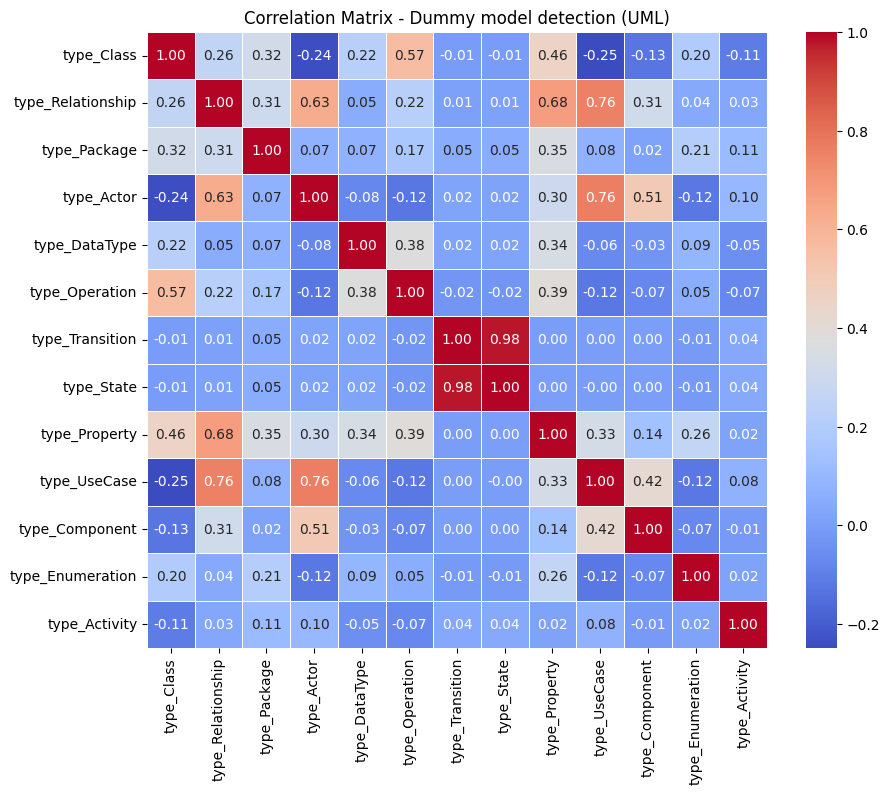

In [ ]:
# Correlation
correlation_matrix = modelset_df_dummy.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Dummy model detection (UML)')
plt.show()



---

❗❗ **No features with a correlation value greater than 0.8, so we are going to keep them all.**


---



In [ ]:
modelset_df_dummy['label'] = modelset_df_dummy['category'].apply(lambda x: 1 if x == 'dummy' else 0)
modelset_df_dummy = modelset_df_dummy.drop(['category'], axis=1)
modelset_df_dummy['label'].value_counts()

In [ ]:
col = modelset_df_dummy.columns
col = col.drop('label')
col

Index(['type_Class', 'type_Relationship', 'type_Package', 'type_Actor',
       'type_DataType', 'type_Operation', 'type_Transition', 'type_State',
       'type_Property', 'type_UseCase', 'type_Component', 'type_Enumeration',
       'type_Activity'],
      dtype='object')

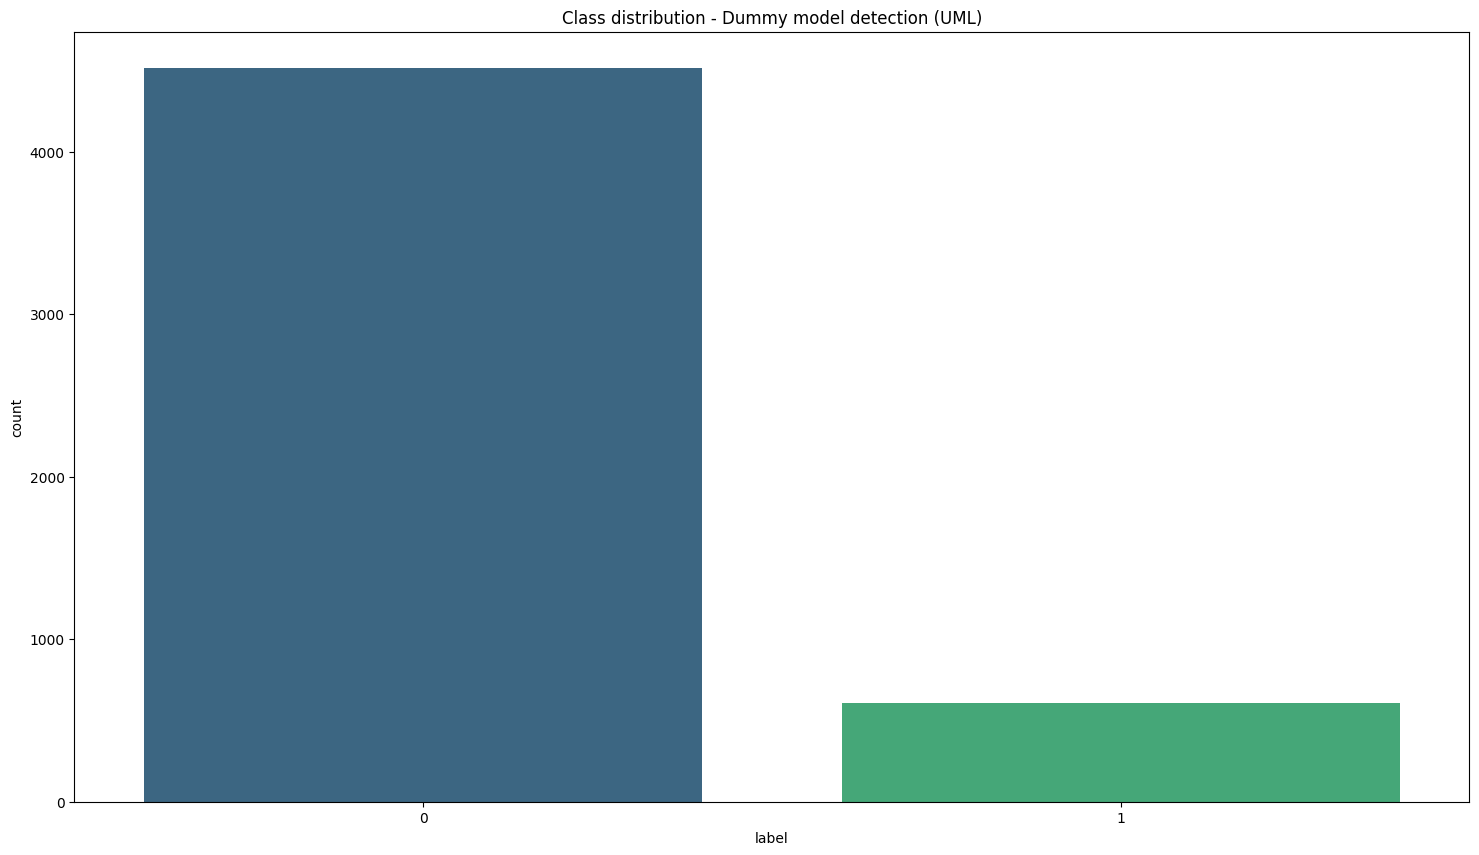

In [ ]:
# Class distribution
class_counts = modelset_df_dummy['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(18, 10))
sns.countplot(x='label', data=modelset_df_dummy, order=class_counts.index, palette='viridis')
plt.title('Class distribution - Dummy model detection (UML)')
plt.show()



---

❗❗❗ **We verify that there is class imbalance**

---



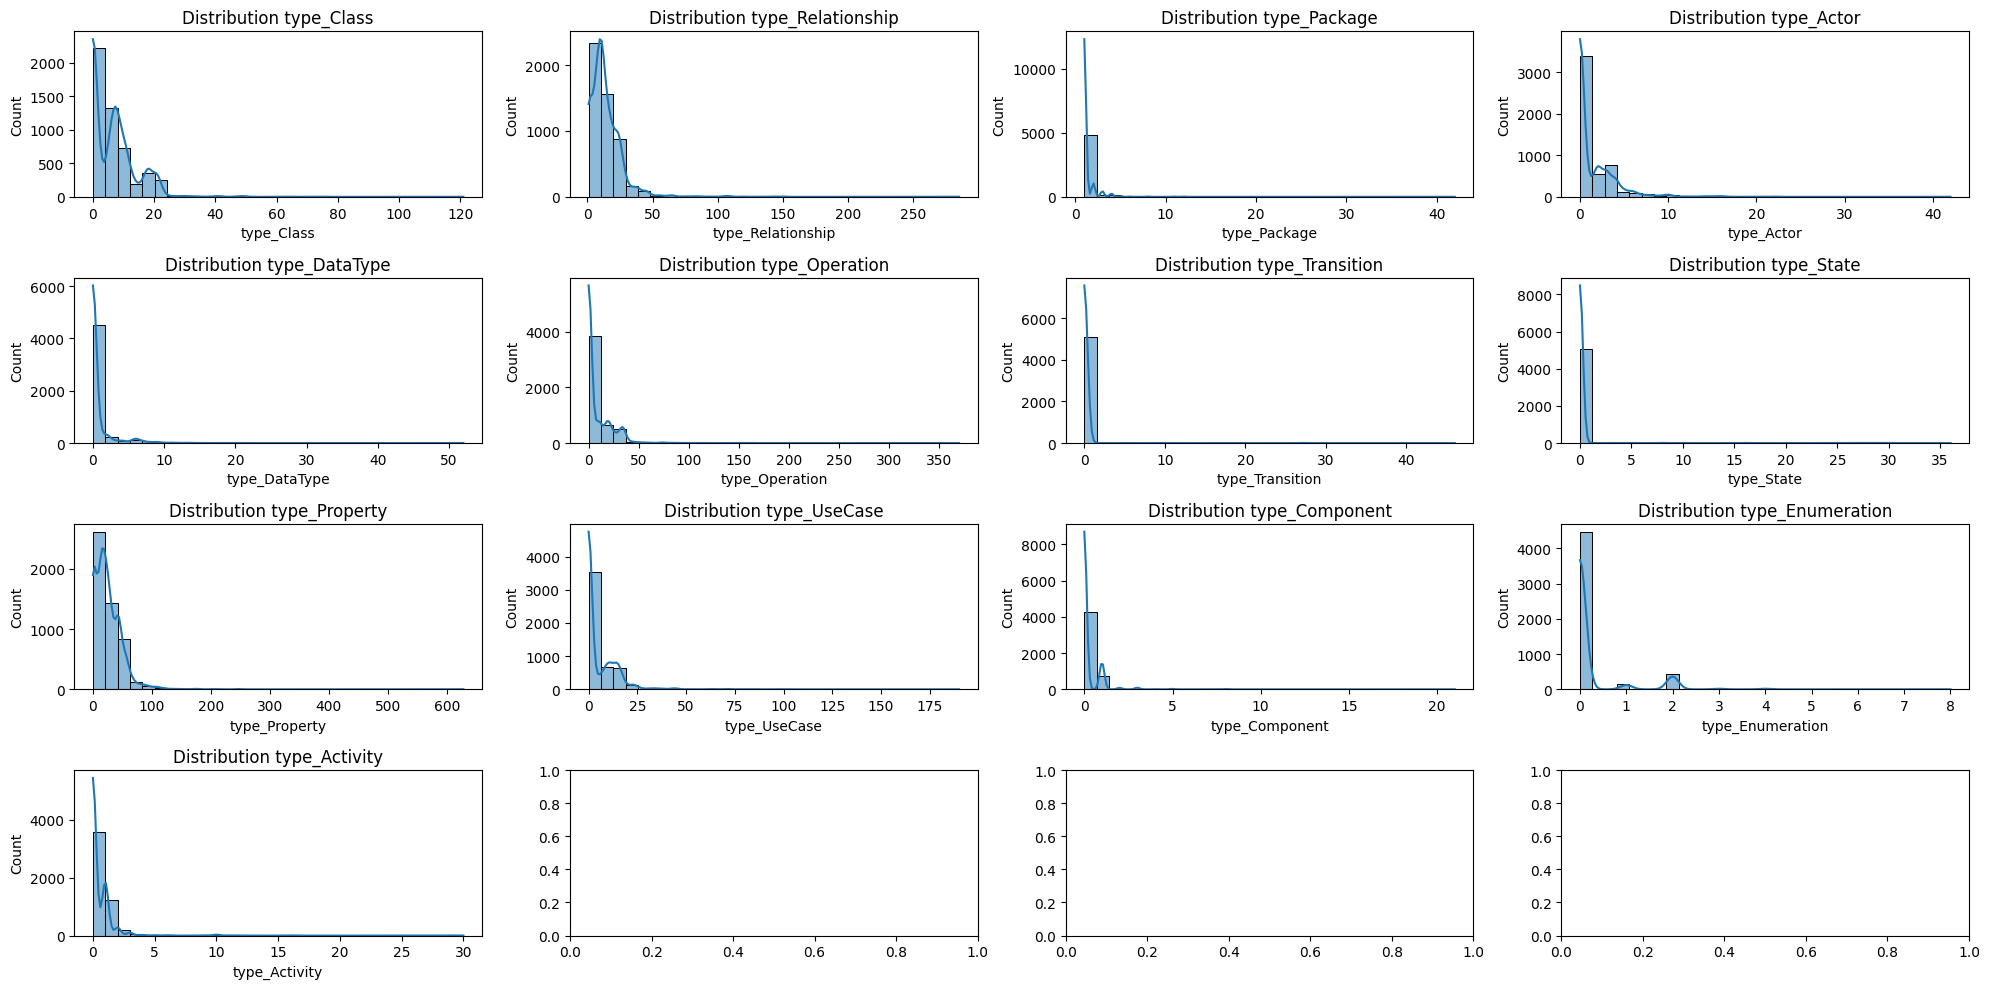

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
axes = axes.flatten()
for i, feature in enumerate(col):
    sns.histplot(modelset_df_dummy[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

# Models:

We perform the dataset splitting and data scaling. Afterward, we conduct a search for the best hyperparameters for our algorithms and define them with the best configuration found. Finally, we evaluate the performance.

In [ ]:
X = modelset_df_dummy[col]
Y = modelset_df_dummy['label']
X_train_split, X_test_split, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
X_train_split

,type_Class,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Activity
1613,9,22,1,3,1,10,0,0,62,13,1,0,0
667,6,5,1,0,2,3,0,0,25,0,0,0,1
1907,0,1,1,0,0,0,0,0,0,0,0,0,1
4578,4,19,1,3,0,14,0,0,42,9,0,0,1
2053,22,28,1,1,8,11,0,0,62,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,6,6,2,0,0,0,0,0,16,0,0,0,0
3881,0,1,1,0,0,0,0,0,0,0,0,0,1
436,11,10,1,0,0,25,0,0,23,0,0,0,0
4521,21,10,1,0,0,10,0,0,18,0,0,0,0


In [ ]:
X_test_split

,type_Class,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Activity
4184,0,23,1,2,0,0,0,0,12,18,0,0,0
741,21,10,1,0,0,10,0,0,16,0,0,0,0
4781,0,1,1,0,0,0,0,0,0,0,0,0,1
1799,0,23,1,6,0,0,0,0,40,13,0,0,0
4634,21,10,1,0,0,10,0,0,17,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0,1,1,0,0,0,0,0,0,0,0,0,1
3112,8,12,1,0,0,1,0,0,44,0,0,2,1
3946,12,16,1,0,7,26,0,0,62,0,0,0,0
3465,10,18,1,0,2,21,0,0,31,0,0,0,0


In [ ]:
X_train_index = X_train_split.index
X_test_index = X_test_split.index

scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train_split)
X_train = pd.DataFrame(X_train_scal, columns=X_train_split.columns, index=X_train_index)

X_test_scal = scaler.transform(X_test_split)
X_test = pd.DataFrame(X_test_scal, columns=X_test_split.columns, index=X_test_index)

In [ ]:
X_train

,type_Class,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Activity
1613,0.304197,0.548899,-0.234295,0.619532,0.104833,0.130203,-0.076325,-0.075839,1.424328,0.810027,1.049140,-0.341387,-0.341159
667,-0.087507,-0.640239,-0.234295,-0.536125,0.464718,-0.317635,-0.076325,-0.075839,-0.024340,-0.521593,-0.309284,-0.341387,0.346919
1907,-0.870914,-0.920036,-0.234295,-0.536125,-0.255053,-0.509565,-0.076325,-0.075839,-1.003169,-0.521593,-0.309284,-0.341387,0.346919
4578,-0.348643,0.339051,-0.234295,0.619532,-0.255053,0.386110,-0.076325,-0.075839,0.641264,0.400297,-0.309284,-0.341387,0.346919
2053,2.001580,0.968594,-0.234295,-0.150906,2.624033,0.194179,-0.076325,-0.075839,1.424328,-0.419161,-0.309284,-0.341387,0.346919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,-0.087507,-0.570289,0.623432,-0.536125,-0.255053,-0.509565,-0.076325,-0.075839,-0.376718,-0.521593,-0.309284,-0.341387,-0.341159
3881,-0.870914,-0.920036,-0.234295,-0.536125,-0.255053,-0.509565,-0.076325,-0.075839,-1.003169,-0.521593,-0.309284,-0.341387,0.346919
436,0.565333,-0.290492,-0.234295,-0.536125,-0.255053,1.089854,-0.076325,-0.075839,-0.102646,-0.521593,-0.309284,-0.341387,-0.341159
4521,1.871012,-0.290492,-0.234295,-0.536125,-0.255053,0.130203,-0.076325,-0.075839,-0.298412,-0.521593,-0.309284,-0.341387,-0.341159


In [ ]:
X_test

,type_Class,type_Relationship,type_Package,type_Actor,type_DataType,type_Operation,type_Transition,type_State,type_Property,type_UseCase,type_Component,type_Enumeration,type_Activity
4184,-0.870914,0.618848,-0.234295,0.234313,-0.255053,-0.509565,-0.076325,-0.075839,-0.533331,1.322188,-0.309284,-0.341387,-0.341159
741,1.871012,-0.290492,-0.234295,-0.536125,-0.255053,0.130203,-0.076325,-0.075839,-0.376718,-0.521593,-0.309284,-0.341387,-0.341159
4781,-0.870914,-0.920036,-0.234295,-0.536125,-0.255053,-0.509565,-0.076325,-0.075839,-1.003169,-0.521593,-0.309284,-0.341387,0.346919
1799,-0.870914,0.618848,-0.234295,1.775188,-0.255053,-0.509565,-0.076325,-0.075839,0.562958,0.810027,-0.309284,-0.341387,-0.341159
4634,1.871012,-0.290492,-0.234295,-0.536125,-0.255053,0.130203,-0.076325,-0.075839,-0.337565,-0.521593,-0.309284,-0.341387,-0.341159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,-0.870914,-0.920036,-0.234295,-0.536125,-0.255053,-0.509565,-0.076325,-0.075839,-1.003169,-0.521593,-0.309284,-0.341387,0.346919
3112,0.173629,-0.150594,-0.234295,-0.536125,-0.255053,-0.445588,-0.076325,-0.075839,0.719571,-0.521593,-0.309284,2.389711,0.346919
3946,0.695901,0.129203,-0.234295,-0.536125,2.264147,1.153831,-0.076325,-0.075839,1.424328,-0.521593,-0.309284,-0.341387,-0.341159
3465,0.434765,0.269102,-0.234295,-0.536125,0.464718,0.833947,-0.076325,-0.075839,0.210579,-0.521593,-0.309284,-0.341387,-0.341159


In [ ]:
#X_train.to_csv('uml_dummy_x_train.csv')
#y_train.to_csv('uml_dummy_y_train.csv')
#X_test.to_csv('uml_dummy_x_test.csv')
#y_test.to_csv('uml_dummy_y_test.csv')

In [ ]:
score_result = pd.DataFrame(columns=['Model', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-score'])

## **SVC**:

In [ ]:
model = SVC(random_state=42, probability=True)
params={'C':[0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],'kernel':['linear','rbf','sigmoid'],'gamma':['scale','auto', 0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0], 'class_weight':[None, 'balanced']}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
svc = SVC(C=300.0, gamma=0.1, probability=True, random_state=42)

In [ ]:
model_svc = svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = model_svc.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_svc.squeeze()})
print(df_pred)

      Actual  Predicted
4184       0          0
741        1          1
4781       0          0
1799       0          0
4634       1          1
...      ...        ...
1321       0          0
3112       0          0
3946       0          0
3465       0          0
1014       0          0

[1536 rows x 2 columns]


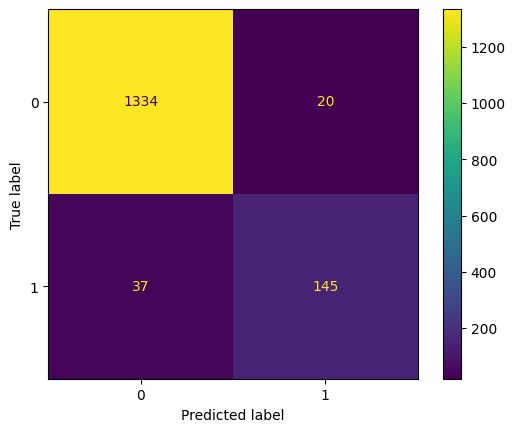

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_display_svc = ConfusionMatrixDisplay(cm_svc).plot()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.8909661239794179
Recall: 0.7967032967032966
Precision: 0.8787878787878788
F1-score: 0.8357348703170029


In [ ]:
print("Accuracy test: ", model_svc.score(X_test, y_test))
print("Accuracy train: ", model_svc.score(X_train, y_train))

Accuracy test:  0.962890625
Accuracy train:  0.9737723214285714


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(svc, X_test_split, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.82432432 0.90093276 0.86111111 0.82779828 0.84764765] 
 Mean:  0.8523628240786912
Precision:
 [1.         0.96666667 1.         0.88888889 0.92857143] 
 Mean:  0.9568253968253968
Recall:
 [0.64864865 0.80555556 0.72222222 0.66666667 0.7027027 ] 
 Mean:  0.7091591591591591
F1-score:
 [0.78688525 0.87878788 0.83870968 0.76190476 0.8       ] 
 Mean:  0.813257512802727


In [ ]:
score_result= score_result.append({"Model":"SVC","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **RandomForest:**

In [ ]:
model = RandomForestClassifier(random_state=42)
params = {'n_estimators':[50,100,200,300,500],'min_samples_split':[2,3,5,10],'min_samples_leaf':[1,3,5,10],'max_depth':[1,3,5,10,None], 'class_weight':['balanced', None]}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 10, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='f1', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
RandomForestClassifier(min_samples_split=5, n_estimators=300, random_state=42)
0.8492568863706385


In [ ]:
rf = RandomForestClassifier(min_samples_split=5, n_estimators=300, random_state=42)

In [ ]:
model_rf = rf.fit(X_train,y_train)

In [ ]:
y_pred_rf = model_rf.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_rf.squeeze()})
print(df_pred)

      Actual  Predicted
4184       0          0
741        1          1
4781       0          0
1799       0          0
4634       1          1
...      ...        ...
1321       0          0
3112       0          0
3946       0          0
3465       0          0
1014       0          0

[1536 rows x 2 columns]


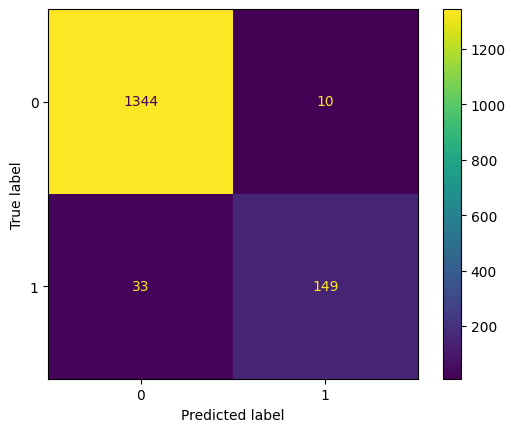

In [ ]:

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(cm_rf).plot()

In [ ]:

accuracy = balanced_accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.9056478971545441
Recall: 0.8186813186813187
Precision: 0.9371069182389937
F1-score: 0.8739002932551319


In [ ]:
print("Accuracy test: ", model_rf.score(X_test, y_test))
print("Accuracy train: ", model_rf.score(X_train, y_train))

Accuracy test:  0.9720052083333334
Accuracy train:  0.9852120535714286


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(rf, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.86117483 0.91297663 0.94075441 0.85373104 0.87652653] 
 Mean:  0.8890326858223536
Precision:
 [0.93103448 0.9375     0.94117647 0.86666667 0.96551724] 
 Mean:  0.9283789722785665
Recall:
 [0.72972973 0.83333333 0.88888889 0.72222222 0.75675676] 
 Mean:  0.7861861861861863
F1-score:
 [0.81818182 0.88235294 0.91428571 0.78787879 0.84848485] 
 Mean:  0.8502368220015277


In [ ]:
score_result= score_result.append({"Model":"RF","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **KNN:**

In [ ]:
model = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,7,10,20],'weights':['uniform','distance'],'leaf_size':[5,10,30,50,100],'p':[1,2,3]}
grid = GridSearchCV(model, params, cv=5, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 30, 50, 100],
                         'n_neighbors': [2, 3, 4, 5, 7, 10, 20], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'leaf_size': 5, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=5, n_neighbors=3, p=1, weights='distance')
0.8203669052630298


In [ ]:
knn = KNeighborsClassifier(leaf_size=5, n_neighbors=3, p=1, weights='distance')

In [ ]:
model_knn = knn.fit(X_train,y_train)

In [ ]:
y_pred_knn = model_knn.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_knn.squeeze()})
print(df_pred)

      Actual  Predicted
4184       0          0
741        1          1
4781       0          0
1799       0          0
4634       1          1
...      ...        ...
1321       0          0
3112       0          0
3946       0          0
3465       0          0
1014       0          0

[1536 rows x 2 columns]


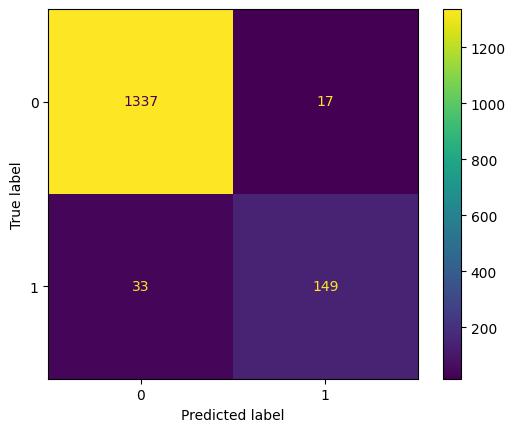

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(cm_knn).plot()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.9030629636242635
Recall: 0.8186813186813187
Precision: 0.8975903614457831
F1-score: 0.8563218390804598


In [ ]:
print("Accuracy test: ", model_knn.score(X_test, y_test))
print("Accuracy train: ", model_knn.score(X_train, y_train))

Accuracy test:  0.9674479166666666
Accuracy train:  0.9896763392857143


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(knn, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision', 'recall','f1'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision'], "\n Mean: ", np.mean(cv_results['test_precision']))
print("Recall:\n", cv_results['test_recall'], "\n Mean: ", np.mean(cv_results['test_recall']))
print("F1-score:\n", cv_results['test_f1'], "\n Mean: ", np.mean(cv_results['test_f1']))

Accuracy:
 [0.87653336 0.92686552 0.93706437 0.84819598 0.85930931] 
 Mean:  0.8895937080992432
Precision:
 [0.96551724 0.93939394 0.88888889 0.78787879 0.9       ] 
 Mean:  0.8963357715081853
Recall:
 [0.75675676 0.86111111 0.88888889 0.72222222 0.72972973] 
 Mean:  0.7917417417417418
F1-score:
 [0.84848485 0.89855072 0.88888889 0.75362319 0.80597015] 
 Mean:  0.8391035599341894


In [ ]:
score_result= score_result.append({"Model":"KNN","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision']), "Recall":np.mean(cv_results['test_recall']), "F1-score":np.mean(cv_results['test_f1'])}, ignore_index=True)

## **Results:**

In [ ]:
score_result

,Model,Balanced Accuracy,Precision,Recall,F1-score
0,SVC,0.852363,0.956825,0.709159,0.813258
1,RF,0.889033,0.928379,0.786186,0.850237
2,KNN,0.889594,0.896336,0.791742,0.839104


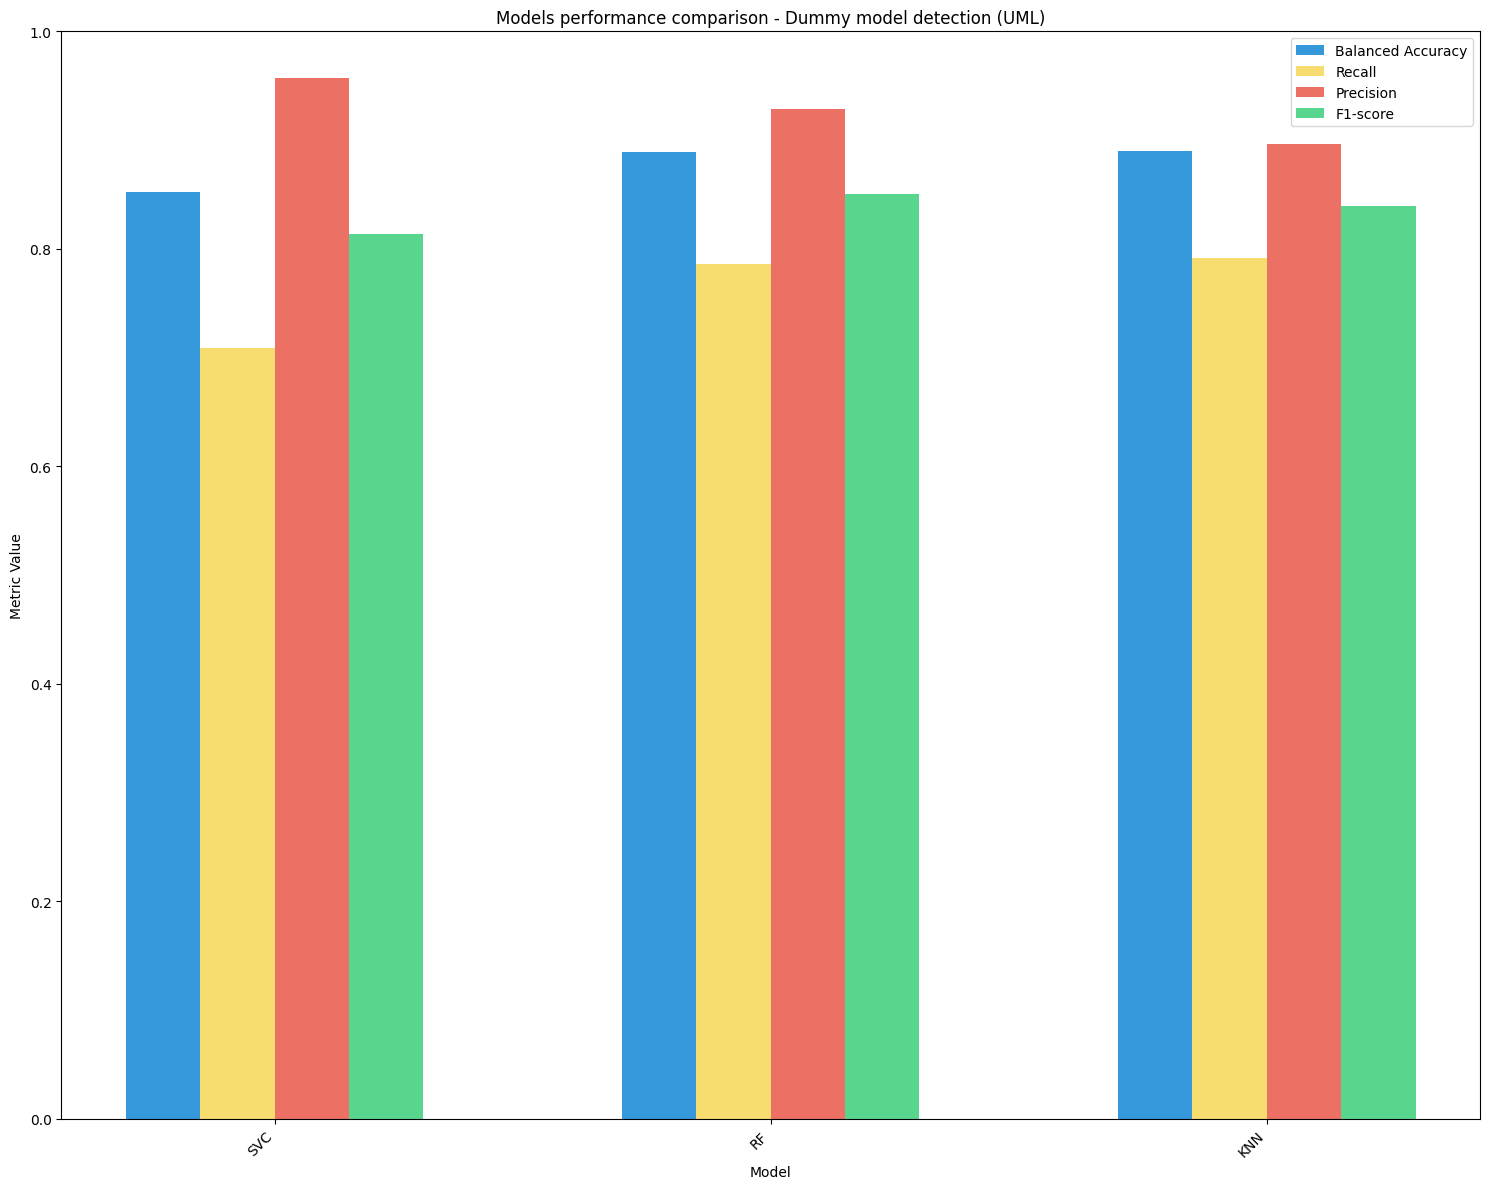

In [ ]:
# plot results
metrics = ['Balanced Accuracy', 'Recall', 'Precision', 'F1-score']
colors = ['#3498DB', '#F7DC6F','#EC7063', '#58D68D']

num_models = len(score_result)
width_bar = 0.15
x = range(num_models)

plt.figure(figsize=(15, 12))


for i, metric in enumerate(metrics):

    pos_x = [pos + i * width_bar for pos in x]


    values_metric = score_result[metric]


    plt.bar(
        pos_x,
        values_metric,
        width=width_bar,
        label=metric,
        color=colors[i],
    )


plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Models performance comparison - Dummy model detection (UML)')
plt.xticks([pos + (len(metrics) - 1) * width_bar / 2 for pos in x], score_result['Model'], rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0, 1)
plt.show()

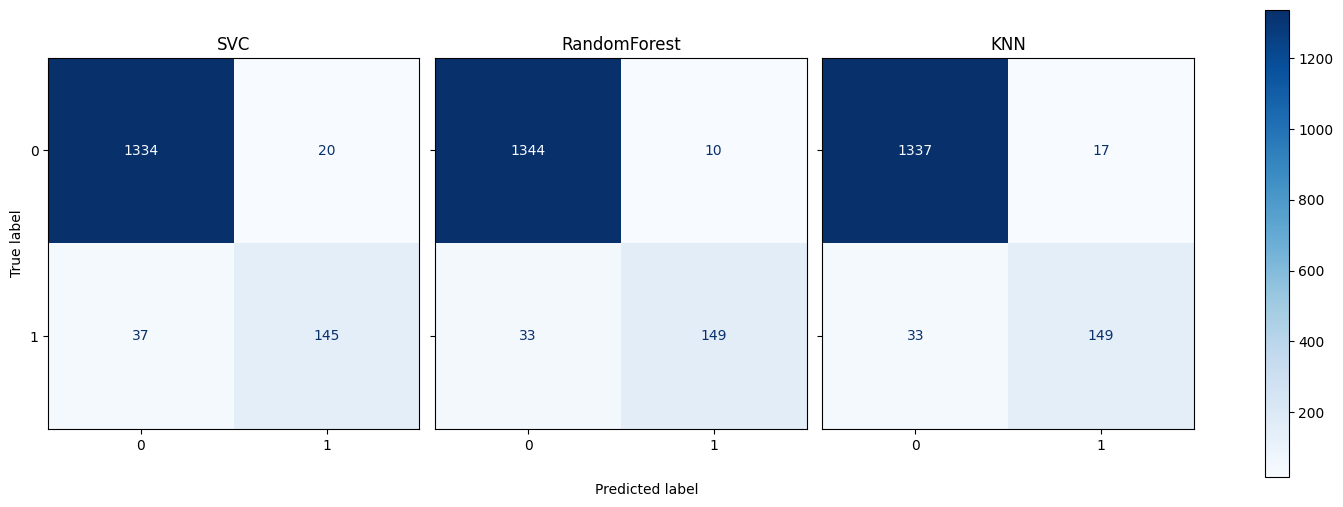

In [ ]:
classifiers = ["SVC", "RandomForest", "KNN"]
matrices_confusion = [cm_svc, cm_rf, cm_knn]
class_names = ["0", "1"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey="row")

for i, (cm, classifier_name) in enumerate(zip(matrices_confusion, classifiers)):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(classifier_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.tight_layout()
fig.text(0.4, 0.0, "Predicted label", ha="left")
fig.colorbar(disp.im_, ax=axes)
plt.show()

# Instance Selection:

In this section, we perform the selection of instances to be studied in local explainability. The selected instances must meet the condition of being classified in the same class by all three models.

In [ ]:
df_results = pd.DataFrame({'Real': y_test, 'Pred_KNN': y_pred_knn, 'Pred_SVC': y_pred_svc, 'Pred_RF': y_pred_rf})

prob_knn_0 = knn.predict_proba(X_test)[:, 0]
prob_svc_0 = svc.predict_proba(X_test)[:, 0]
prob_rf_0 = rf.predict_proba(X_test)[:, 0]
prob_knn_1 = knn.predict_proba(X_test)[:, 1]
prob_svc_1 = svc.predict_proba(X_test)[:, 1]
prob_rf_1 = rf.predict_proba(X_test)[:, 1]

df_results['Prob_KNN_0'] = prob_knn_0
df_results['Prob_KNN_1'] = prob_knn_1
df_results['Prob_SVC_0'] = prob_svc_0
df_results['Prob_SVC_1'] = prob_svc_1
df_results['Prob_RF_0'] = prob_rf_0
df_results['Prob_RF_1'] = prob_rf_1

df_preds = df_results[(df_results['Pred_KNN'] == df_results['Pred_SVC']) &
                             (df_results['Pred_SVC'] == df_results['Pred_RF'])]

df_tp = df_preds[(df_preds['Real'] == 1) &
                      (df_preds['Pred_KNN'] == 1) &
                      (df_preds['Pred_SVC'] == 1) &
                      (df_preds['Pred_RF'] == 1)]

df_tn = df_preds[(df_preds['Real'] == 0) &
                      (df_preds['Pred_KNN'] == 0) &
                      (df_preds['Pred_SVC'] == 0) &
                      (df_preds['Pred_RF'] == 0)]

df_fn = df_preds[(df_preds['Real'] == 1) &
                      (df_preds['Pred_KNN'] == 0) &
                      (df_preds['Pred_SVC'] == 0) &
                      (df_preds['Pred_RF'] == 0)]

df_fp = df_preds[(df_preds['Real'] == 0) &
                      (df_preds['Pred_KNN'] == 1) &
                      (df_preds['Pred_SVC'] == 1) &
                      (df_preds['Pred_RF'] == 1)]

In [ ]:
df_preds

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
4184,0,0,0,0,1.000000,0.000000,0.982690,0.017310,0.970722,0.029278
741,1,1,1,1,0.000000,1.000000,0.073870,0.926130,0.000000,1.000000
4781,0,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
1799,0,0,0,0,1.000000,0.000000,0.977374,0.022626,1.000000,0.000000
4634,1,1,1,1,0.000000,1.000000,0.071390,0.928610,0.004323,0.995677
...,...,...,...,...,...,...,...,...,...,...
1321,0,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
3112,0,0,0,0,1.000000,0.000000,0.999920,0.000080,1.000000,0.000000
3946,0,0,0,0,1.000000,0.000000,0.999988,0.000012,1.000000,0.000000
3465,0,0,0,0,1.000000,0.000000,0.999977,0.000023,1.000000,0.000000


In [ ]:
df_tp

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
741,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
4634,1,1,1,1,0.0,1.0,0.07139,0.92861,0.004323,0.995677
3622,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
4945,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
2480,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2283,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
1363,1,1,1,1,0.0,1.0,0.06072,0.93928,0.000000,1.000000
1588,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000
1988,1,1,1,1,0.0,1.0,0.07387,0.92613,0.000000,1.000000


In [ ]:
df_tn

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
4184,0,0,0,0,1.000000,0.000000,0.982690,0.017310,0.970722,0.029278
4781,0,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
1799,0,0,0,0,1.000000,0.000000,0.977374,0.022626,1.000000,0.000000
2265,0,0,0,0,1.000000,0.000000,0.999994,0.000006,1.000000,0.000000
4697,0,0,0,0,1.000000,0.000000,0.874867,0.125133,0.948974,0.051026
...,...,...,...,...,...,...,...,...,...,...
1321,0,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
3112,0,0,0,0,1.000000,0.000000,0.999920,0.000080,1.000000,0.000000
3946,0,0,0,0,1.000000,0.000000,0.999988,0.000012,1.000000,0.000000
3465,0,0,0,0,1.000000,0.000000,0.999977,0.000023,1.000000,0.000000


In [ ]:
df_fp

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
4197,0,1,1,1,0.000000,1.000000,0.255058,0.744942,0.243626,0.756374
3625,0,1,1,1,0.327091,0.672909,0.105722,0.894278,0.391644,0.608356
940,0,1,1,1,0.000000,1.000000,0.337698,0.662302,0.414639,0.585361
590,0,1,1,1,0.371356,0.628644,0.235349,0.764651,0.302807,0.697193
4446,0,1,1,1,0.000000,1.000000,0.130899,0.869101,0.425094,0.574906


In [ ]:
df_fn

,Real,Pred_KNN,Pred_SVC,Pred_RF,Prob_KNN_0,Prob_KNN_1,Prob_SVC_0,Prob_SVC_1,Prob_RF_0,Prob_RF_1
4629,1,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
1274,1,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
3963,1,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486
718,1,0,0,0,1.000000,0.000000,0.973915,0.026085,0.643775,0.356225
1348,1,0,0,0,0.688873,0.311127,0.885822,0.114178,0.763145,0.236855
3239,1,0,0,0,1.000000,0.000000,0.917925,0.082075,0.959799,0.040201
2039,1,0,0,0,1.000000,0.000000,0.997021,0.002979,0.974944,0.025056
917,1,0,0,0,1.000000,0.000000,0.874867,0.125133,0.948974,0.051026
1716,1,0,0,0,1.000000,0.000000,0.789227,0.210773,0.897668,0.102332
4142,1,0,0,0,0.666667,0.333333,0.869654,0.130346,0.915514,0.084486


In [ ]:
dfs_select = ["df_tp", "df_tn", "df_fp", "df_fn"]
inst_select_indexes = {}

for df_select in dfs_select:
    df = globals()[df_select]
    if len(df) > 100:
        indexes_inst = df.sample(n=100, random_state=42).index
    else:
        indexes_inst = df.index
    indexes_inst = list(indexes_inst)
    inst_select_indexes[df_select] = indexes_inst

In [ ]:
with open('uml_dummy_indexes.pickle', 'wb') as f:
    pickle.dump(inst_select_indexes, f)

In [ ]:
index_max_prob_tp_knn = df_tp['Prob_KNN_1'].idxmax()
index_max_prob_tp_svc = df_tp['Prob_SVC_1'].idxmax()
index_max_prob_tp_rf = df_tp['Prob_RF_1'].idxmax()

index_max_prob_tn_knn = df_tn['Prob_KNN_0'].idxmax()
index_max_prob_tn_svc = df_tn['Prob_SVC_0'].idxmax()
index_max_prob_tn_rf = df_tn['Prob_RF_0'].idxmax()

index_max_prob_fp_knn = df_fp['Prob_KNN_1'].idxmax()
index_max_prob_fp_svc = df_fp['Prob_SVC_1'].idxmax()
index_max_prob_fp_rf = df_fp['Prob_RF_1'].idxmax()

index_max_prob_fn_knn = df_fn['Prob_KNN_0'].idxmax()
index_max_prob_fn_svc = df_fn['Prob_SVC_0'].idxmax()
index_max_prob_fn_rf = df_fn['Prob_RF_0'].idxmax()

In [ ]:
print("Instance with highest probability for TP - KNN: ", df_results.loc[index_max_prob_tp_knn].name)
print("Instance with highest probability for TP - SVC: ", df_results.loc[index_max_prob_tp_svc].name)
print("Instance with highest probability for TP - RF: ", df_results.loc[index_max_prob_tp_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for TN - KNN: ", df_results.loc[index_max_prob_tn_knn].name)
print("Instance with highest probability for TN - SVC: ", df_results.loc[index_max_prob_tn_svc].name)
print("Instance with highest probability for TN - RF: ", df_results.loc[index_max_prob_tn_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for FP - KNN: ", df_results.loc[index_max_prob_fp_knn].name)
print("Instance with highest probability for FP - SVC: ", df_results.loc[index_max_prob_fp_svc].name)
print("Instance with highest probability for FP - RF: ", df_results.loc[index_max_prob_fp_rf].name)
print("-----------------------------------------------------------")
print("Instance with highest probability for FN - KNN: ", df_results.loc[index_max_prob_fn_knn].name)
print("Instance with highest probability for FN - SVC: ", df_results.loc[index_max_prob_fn_svc].name)
print("Instance with highest probability for FN - RF: ", df_results.loc[index_max_prob_fn_rf].name)

Instance with highest probability for TP - KNN:  741
Instance with highest probability for TP - SVC:  3537
Instance with highest probability for TP - RF:  741
-----------------------------------------------------------
Instance with highest probability for TN - KNN:  4184
Instance with highest probability for TN - SVC:  487
Instance with highest probability for TN - RF:  1799
-----------------------------------------------------------
Instance with highest probability for FP - KNN:  4197
Instance with highest probability for FP - SVC:  3625
Instance with highest probability for FP - RF:  4197
-----------------------------------------------------------
Instance with highest probability for FN - KNN:  718
Instance with highest probability for FN - SVC:  2039
Instance with highest probability for FN - RF:  21


In [ ]:
inst_tp_knn = df_results.loc[index_max_prob_tp_knn].name
inst_tp_svc = df_results.loc[index_max_prob_tp_svc].name
inst_tp_rf = df_results.loc[index_max_prob_tp_rf].name

inst_tn_knn = df_results.loc[index_max_prob_tn_knn].name
inst_tn_svc = df_results.loc[index_max_prob_tn_svc].name
inst_tn_rf = df_results.loc[index_max_prob_tn_rf].name

inst_fp_knn = df_results.loc[index_max_prob_fp_knn].name
inst_fp_svc = df_results.loc[index_max_prob_fp_svc].name
inst_fp_rf = df_results.loc[index_max_prob_fp_rf].name

inst_fn_knn = df_results.loc[index_max_prob_fn_knn].name
inst_fn_svc = df_results.loc[index_max_prob_fn_svc].name
inst_fn_rf = df_results.loc[index_max_prob_fn_rf].name

# Explainability:

# Global Explainability:

We conduct the study of global explainability using permutation importance.

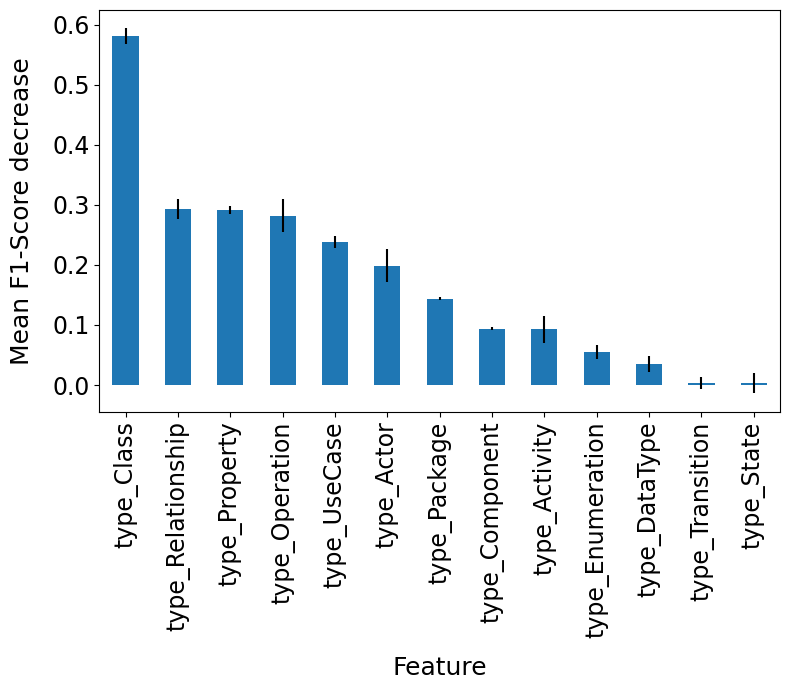

In [ ]:
permu = permutation_importance(model_svc, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_dummy_globSVC.pdf')
plt.show()

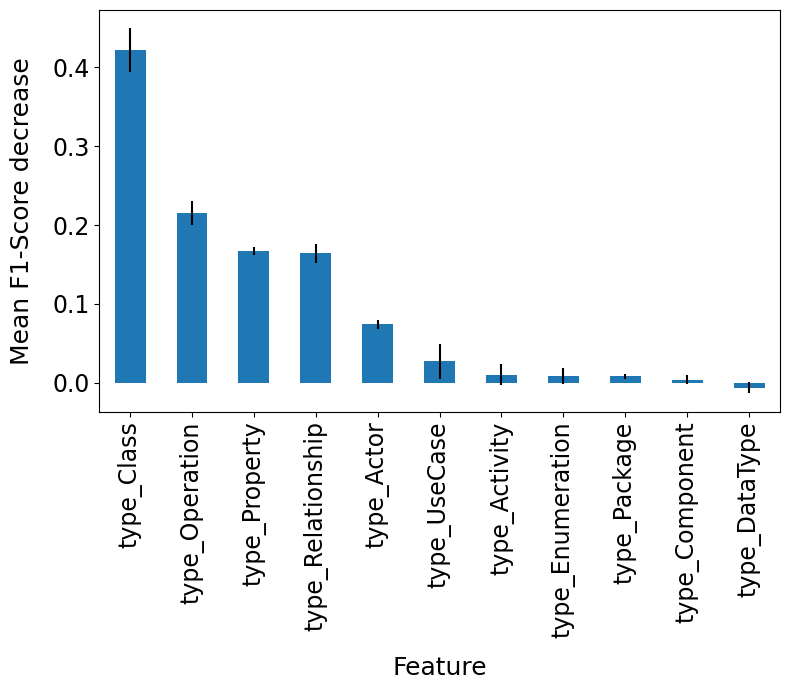

In [ ]:
permu = permutation_importance(model_rf, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_dummy_globRF.pdf')
plt.show()

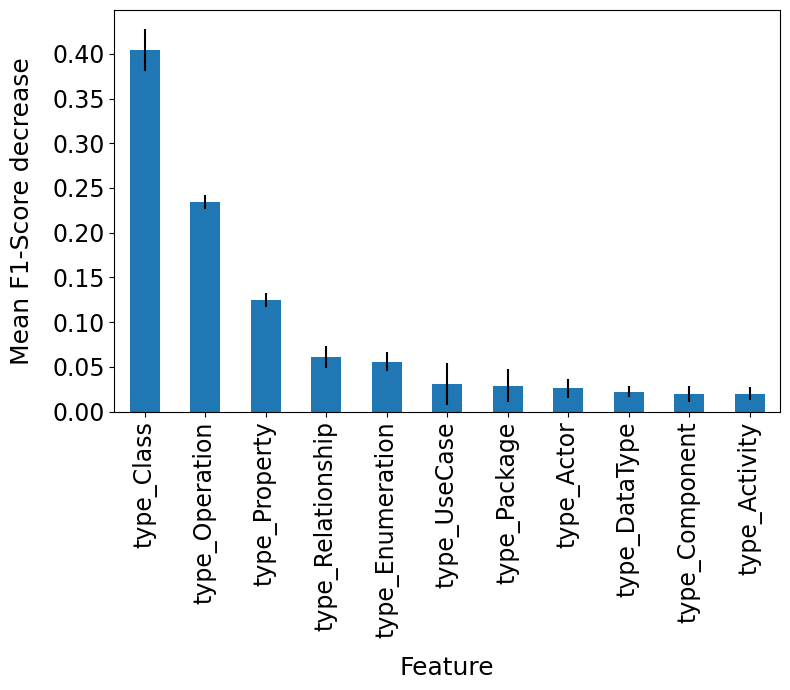

In [ ]:
permu = permutation_importance(model_knn, X_test, y_test, scoring='f1', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('uml_dummy_globKNN.pdf')
plt.show()

# Local Explainability:

Finally, we obtain explanations for the selected instances and calculate the disagreement metrics.

In [ ]:
num_features = len(col)
top_num_features = 10

## SVC:

In [ ]:
exp = dx.Explainer(model_svc, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 3584 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3584 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7a781727ea70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1e-07, mean = 0.119, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.994, mean = -0.000588, max = 0.995
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_svc]
instance_tn = X_test.loc[inst_tn_svc]
instance_fp = X_test.loc[inst_fp_svc]
instance_fn = X_test.loc[inst_fn_svc]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

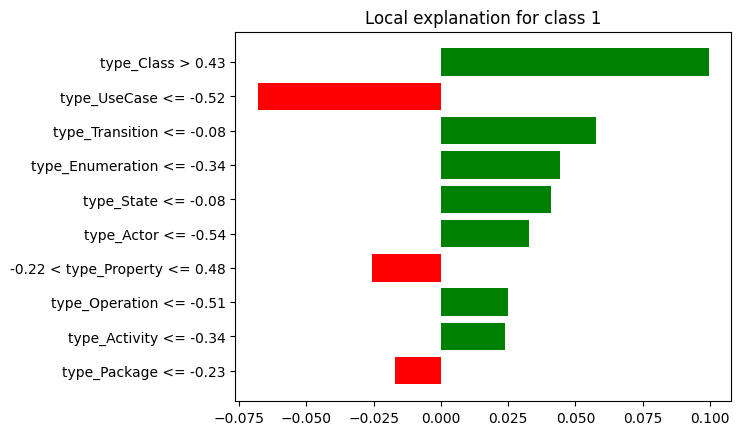

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_svc_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['type_Relationship', 'type_Class', 'type_Actor', 'type_Property', 'type_UseCase', 'type_Operation', 'type_Activity', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Class', 'type_Property', 'type_Operation', 'type_Actor', 'type_UseCase', 'type_Package', 'type_Activity', 'type_Enumeration', 'type_Relationship', 'type_DataType']
['type_Class', 'type_UseCase', 'type_Transition', 'type_Enumeration', 'type_State', 'type_Actor', 'type_Property', 'type_Operation', 'type_Activity', 'type_Package']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1         type_Class        2  Positive
2         type_Actor        3  Positive
3      type_Property        4  Positive
4       type_UseCase        5  Negative
5

In [ ]:
df_final_svc_tp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Positive       9  Positive       -         -
type_Class                2  Positive       1  Positive       1  Positive
type_Actor                3  Positive       4  Positive       6  Positive
type_Property             4  Positive       2  Positive       7  Negative
type_UseCase              5  Negative       5  Negative       2  Negative
type_Operation            6  Positive       3  Positive       8  Positive
type_Activity             7  Positive       7  Positive       9  Positive
type_Enumeration          8  Positive       8  Positive       4  Positive
type_DataType             9  Positive      10  Positive       -         -
type_Package             10  Positive       6  Positive      10  Negative
type_State                -         -       -         -       5  Positive
type_Transition           -         -       -         -       3  Positive

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

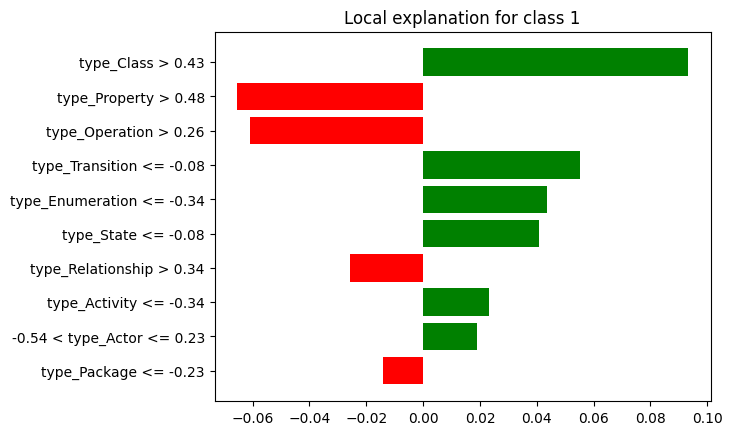

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_svc_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['type_Operation', 'type_Class', 'type_UseCase', 'type_Activity', 'type_Enumeration', 'type_Relationship', 'type_Package', 'type_DataType', 'type_Transition', 'type_Component']
['type_Property', 'type_Relationship', 'type_Class', 'type_Operation', 'type_Actor', 'type_Activity', 'type_Package', 'type_UseCase', 'type_Enumeration', 'type_Component']
['type_Class', 'type_Property', 'type_Operation', 'type_Transition', 'type_Enumeration', 'type_State', 'type_Relationship', 'type_Activity', 'type_Actor', 'type_Package']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Activity', 'type_Enumeration', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1         type_Class        2  Positive
2       type_UseCase        3  Negative
3      type_Activity        4  Positive
4   type_En

In [ ]:
df_final_svc_tn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       4  Negative       3  Negative
type_Class                2  Positive       3  Positive       1  Positive
type_UseCase              3  Negative       8  Positive       -         -
type_Activity             4  Positive       6  Positive       8  Positive
type_Enumeration          5  Positive       9  Positive       5  Positive
type_Relationship         6  Negative       2  Negative       7  Negative
type_Package              7  Positive       7  Positive      10  Negative
type_DataType             8  Positive       -         -       -         -
type_Transition           9  Positive       -         -       4  Positive
type_Component           10  Negative      10  Positive       -         -
type_Actor                -         -       5  Negative       9  Positive
type_Property             -         -       1  Negative       2  Negative
type_State                -         -       -         -       6  Positive

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

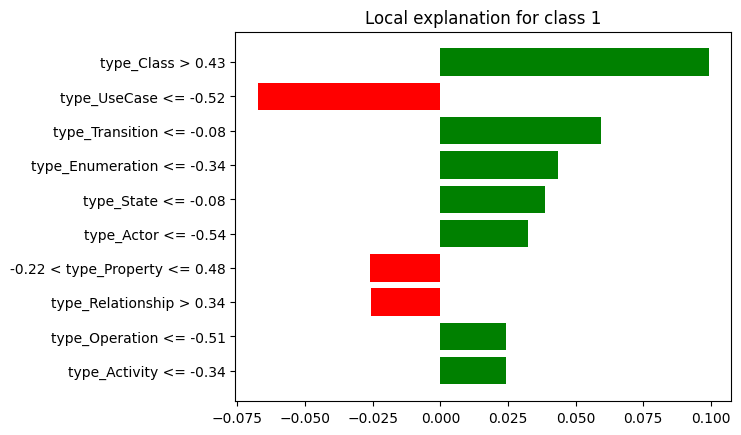

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_svc_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['type_Class', 'type_Property', 'type_Actor', 'type_Operation', 'type_UseCase', 'type_Activity', 'type_Enumeration', 'type_Relationship', 'type_DataType', 'type_Package']
['type_Class', 'type_Operation', 'type_Actor', 'type_Property', 'type_Relationship', 'type_Activity', 'type_UseCase', 'type_Enumeration', 'type_Package', 'type_DataType']
['type_Class', 'type_UseCase', 'type_Transition', 'type_Enumeration', 'type_State', 'type_Actor', 'type_Property', 'type_Relationship', 'type_Operation', 'type_Activity']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Positive
1      type_Property        2  Positive
2         type_Actor        3  Positive
3     type_Operation        4  Positive
4       type_UseCase        5  Negat

In [ ]:
df_final_svc_fp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive       1  Positive       1  Positive
type_Property             2  Positive       4  Positive       7  Negative
type_Actor                3  Positive       3  Positive       6  Positive
type_Operation            4  Positive       2  Positive       9  Positive
type_UseCase              5  Negative       7  Negative       2  Negative
type_Activity             6  Positive       6  Positive      10  Positive
type_Enumeration          7  Positive       8  Positive       4  Positive
type_Relationship         8  Positive       5  Negative       8  Negative
type_DataType             9  Positive      10  Positive       -         -
type_Package             10  Positive       9  Positive       -         -
type_State                -         -       -         -       5  Positive
type_Transition           -         -       -         -       3  Positive

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

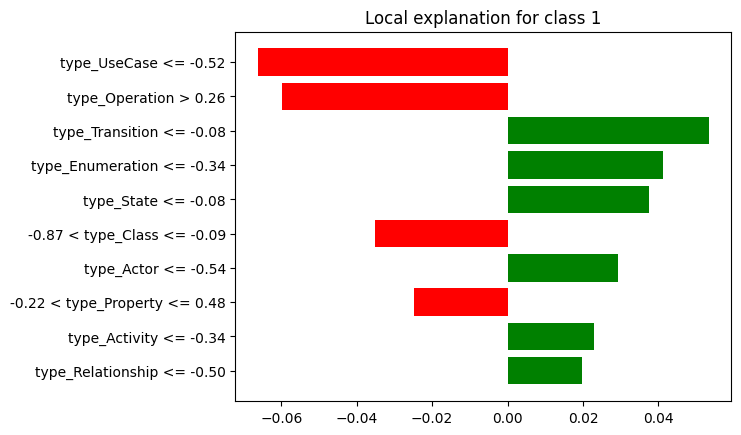

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_svc_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['type_Relationship', 'type_DataType', 'type_Component', 'type_Operation', 'type_Class', 'type_Activity', 'type_UseCase', 'type_Enumeration', 'type_Package', 'type_Actor']
['type_Operation', 'type_Relationship', 'type_DataType', 'type_Property', 'type_Activity', 'type_Actor', 'type_UseCase', 'type_Class', 'type_Component', 'type_Package']
['type_UseCase', 'type_Operation', 'type_Transition', 'type_Enumeration', 'type_State', 'type_Class', 'type_Actor', 'type_Property', 'type_Activity', 'type_Relationship']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Positive
1      type_DataType        2  Negative
2     type_Component        3  Negative
3     type_Operation        4  Negative
4         type_Clas

In [ ]:
df_final_svc_fn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Positive       2  Positive      10  Positive
type_DataType             2  Negative       3  Negative       -         -
type_Component            3  Negative       9  Negative       -         -
type_Operation            4  Negative       1  Negative       2  Negative
type_Class                5  Negative       8  Negative       6  Negative
type_Activity             6  Positive       5  Positive       9  Positive
type_UseCase              7  Negative       7  Negative       1  Negative
type_Enumeration          8  Positive       -         -       4  Positive
type_Package              9  Positive      10  Positive       -         -
type_Actor               10  Positive       6  Positive       7  Positive
type_Property             -         -       4  Negative       8  Negative
type_State                -         -       -         -       5  Positive
type_Transition           -         -       -         -       3  Positive

### Results SVC:

In [ ]:
df_topfeatures_tp_svc = top5_features(df_final_svc_tp, 'TP')
df_topfeatures_tn_svc = top5_features(df_final_svc_tn, 'TN')
df_topfeatures_fp_svc = top5_features(df_final_svc_fp, 'FP')
df_topfeatures_fn_svc = top5_features(df_final_svc_fn, 'FN')

df_topfeatures_svc = pd.concat([df_topfeatures_tp_svc, df_topfeatures_tn_svc, df_topfeatures_fp_svc, df_topfeatures_fn_svc])
df_topfeatures_svc

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Class, type_Property, type_UseCase, type_...","type_Class, type_Property, type_UseCase, type_...","type_Enumeration, type_Class, type_UseCase, ty...",0.8,0.4,0.4
TN,"type_Activity, type_Enumeration, type_UseCase,...","type_Class, type_Property, type_Relationship, ...","type_Enumeration, type_Class, type_Property, t...",0.4,0.6,0.6
FP,"type_Class, type_Property, type_UseCase, type_...","type_Class, type_Property, type_Relationship, ...","type_Enumeration, type_Class, type_UseCase, ty...",0.8,0.4,0.2
FN,"type_Component, type_DataType, type_Class, typ...","type_Activity, type_DataType, type_Property, t...","type_Enumeration, type_UseCase, type_Transitio...",0.6,0.2,0.2


In [ ]:
df_topfeatures_tp_rank_svc = top5_rank(df_final_svc_tp, 'TP')
df_topfeatures_tn_rank_svc = top5_rank(df_final_svc_tn, 'TN')
df_topfeatures_fp_rank_svc = top5_rank(df_final_svc_fp, 'FP')
df_topfeatures_fn_rank_svc = top5_rank(df_final_svc_fn, 'FN')

df_topfeatures_rank_svc = pd.concat([df_topfeatures_tp_rank_svc, df_topfeatures_tn_rank_svc, df_topfeatures_fp_rank_svc, df_topfeatures_fn_rank_svc])
df_topfeatures_rank_svc

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Relationship, 2:type_Class, 3:type_Acto...","1:type_Class, 4:type_Actor, 2:type_Property, 5...","1:type_Class, 2:type_UseCase, 4:type_Enumerati...",0.2,0.0,0.2
TN,"1:type_Operation, 2:type_Class, 3:type_UseCase...","4:type_Operation, 3:type_Class, 2:type_Relatio...","3:type_Operation, 1:type_Class, 5:type_Enumera...",0.0,0.2,0.0
FP,"1:type_Class, 2:type_Property, 3:type_Actor, 4...","1:type_Class, 4:type_Property, 3:type_Actor, 2...","1:type_Class, 2:type_UseCase, 4:type_Enumerati...",0.4,0.2,0.2
FN,"1:type_Relationship, 2:type_DataType, 3:type_C...","2:type_Relationship, 3:type_DataType, 1:type_O...","2:type_Operation, 1:type_UseCase, 4:type_Enume...",0.0,0.0,0.0


In [ ]:
df_topfeatures_tp_sign_svc = top5_sign(df_final_svc_tp, 'TP')
df_topfeatures_tn_sign_svc = top5_sign(df_final_svc_tn, 'TN')
df_topfeatures_fp_sign_svc = top5_sign(df_final_svc_fp, 'FP')
df_topfeatures_fn_sign_svc = top5_sign(df_final_svc_fn, 'FN')

df_topfeatures_sign_svc = pd.concat([df_topfeatures_tp_sign_svc, df_topfeatures_tn_sign_svc, df_topfeatures_fp_sign_svc, df_topfeatures_fn_sign_svc])
df_topfeatures_sign_svc

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Relationship:Positive, type_Class:Positiv...","type_Class:Positive, type_Actor:Positive, type...","type_Class:Positive, type_UseCase:Negative, ty...",0.8,0.4,0.4
TN,"type_Operation:Negative, type_Class:Positive, ...","type_Operation:Negative, type_Class:Positive, ...","type_Operation:Negative, type_Class:Positive, ...",0.4,0.6,0.6
FP,"type_Class:Positive, type_Property:Positive, t...","type_Class:Positive, type_Property:Positive, t...","type_Class:Positive, type_UseCase:Negative, ty...",0.8,0.4,0.2
FN,"type_Relationship:Positive, type_DataType:Nega...","type_Relationship:Positive, type_DataType:Nega...","type_Operation:Negative, type_UseCase:Negative...",0.6,0.2,0.2


In [ ]:
df_topfeatures_tp_rank_sign_svc = top5_rank_sign(df_final_svc_tp, 'TP')
df_topfeatures_tn_rank_sign_svc = top5_rank_sign(df_final_svc_tn, 'TN')
df_topfeatures_fp_rank_sign_svc = top5_rank_sign(df_final_svc_fp, 'FP')
df_topfeatures_fn_rank_sign_svc = top5_rank_sign(df_final_svc_fn, 'FN')

df_topfeatures_rank_sign_svc = pd.concat([df_topfeatures_tp_rank_sign_svc, df_topfeatures_tn_rank_sign_svc, df_topfeatures_fp_rank_sign_svc, df_topfeatures_fn_rank_sign_svc])
df_topfeatures_rank_sign_svc

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Relationship:Positive, 2:type_Class:Pos...","1:type_Class:Positive, 4:type_Actor:Positive, ...","1:type_Class:Positive, 2:type_UseCase:Negative...",0.2,0.0,0.2
TN,"1:type_Operation:Negative, 2:type_Class:Positi...","4:type_Operation:Negative, 3:type_Class:Positi...","3:type_Operation:Negative, 1:type_Class:Positi...",0.0,0.2,0.0
FP,"1:type_Class:Positive, 2:type_Property:Positiv...","1:type_Class:Positive, 4:type_Property:Positiv...","1:type_Class:Positive, 2:type_UseCase:Negative...",0.4,0.2,0.2
FN,"1:type_Relationship:Positive, 2:type_DataType:...","2:type_Relationship:Positive, 3:type_DataType:...","2:type_Operation:Negative, 1:type_UseCase:Nega...",0.0,0.0,0.0


## RF:

In [ ]:
exp = dx.Explainer(model_rf, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 3584 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3584 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7a781727ea70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.118, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.688, mean = -3.92e-05, max = 0.96
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_rf]
instance_tn = X_test.loc[inst_tn_rf]
instance_fp = X_test.loc[inst_fp_rf]
instance_fn = X_test.loc[inst_fn_rf]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

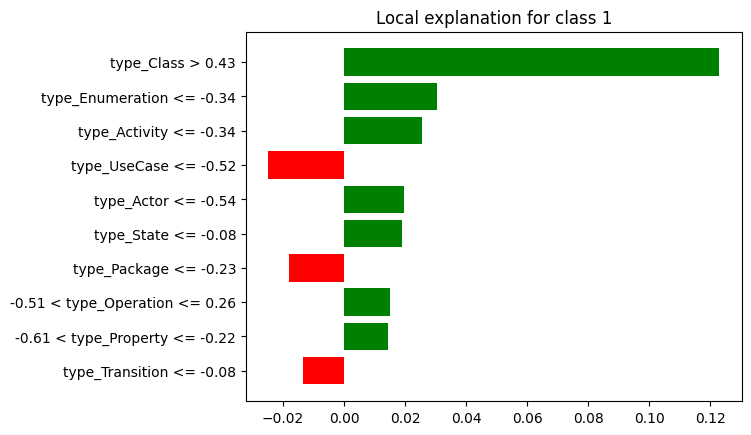

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_rf_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['type_Class', 'type_Property', 'type_Relationship', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Operation', 'type_Enumeration', 'type_DataType', 'type_Component']
['type_Class', 'type_Property', 'type_Operation', 'type_Relationship', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Class', 'type_Enumeration', 'type_Activity', 'type_UseCase', 'type_Actor', 'type_State', 'type_Package', 'type_Operation', 'type_Property', 'type_Transition']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0         type_Class        1  Positive
1      type_Property        2  Positive
2  type_Relationship        3  Positive
3         type_Actor        4  Positive
4      type_Activity 

In [ ]:
df_final_rf_tp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive       1  Positive       1  Positive
type_Property             2  Positive       2  Positive       9  Positive
type_Relationship         3  Positive       4  Positive       -         -
type_Actor                4  Positive       5  Positive       5  Positive
type_Activity             5  Positive       6  Positive       3  Positive
type_UseCase              6  Positive       7  Positive       4  Negative
type_Operation            7  Positive       3  Positive       8  Positive
type_Enumeration          8  Positive       8  Positive       2  Positive
type_DataType             9  Positive       9  Positive       -         -
type_Component           10  Positive       -         -       -         -
type_Package              -         -      10  Positive       7  Negative
type_State                -         -       -         -       6  Positive
type_Transition           -         -       -         -      10  Negative

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

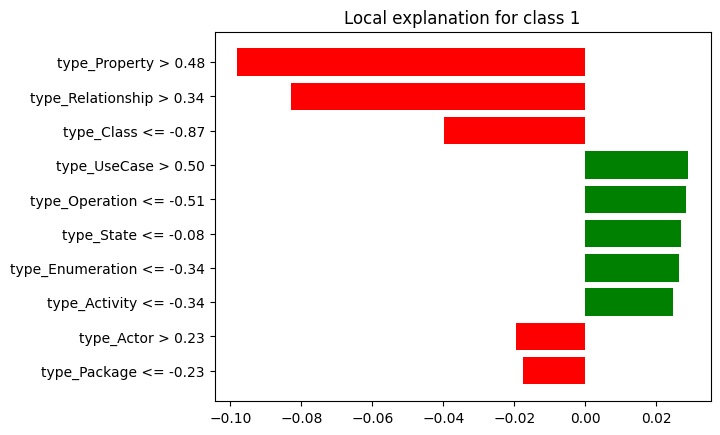

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_rf_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['type_Actor', 'type_UseCase', 'type_Relationship', 'type_Property', 'type_Activity', 'type_Operation', 'type_Class', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Property', 'type_Actor', 'type_Relationship', 'type_UseCase', 'type_Operation', 'type_Class', 'type_Activity', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Property', 'type_Relationship', 'type_Class', 'type_UseCase', 'type_Operation', 'type_State', 'type_Enumeration', 'type_Activity', 'type_Actor', 'type_Package']
['type_Actor', 'type_State', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Negative
1       type_UseCase        2  Positive
2  type_Relationship        3  Negative
3      type_Property        4  Negative
4      type_Activity        5  Positive
5     type_Operati

In [ ]:
df_final_rf_tn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Negative       2  Negative       9  Negative
type_UseCase              2  Positive       4  Positive       4  Positive
type_Relationship         3  Negative       3  Negative       2  Negative
type_Property             4  Negative       1  Negative       1  Negative
type_Activity             5  Positive       7  Positive       8  Positive
type_Operation            6  Positive       5  Positive       5  Positive
type_Class                7  Negative       6  Negative       3  Negative
type_Enumeration          8  Positive       8  Positive       7  Positive
type_DataType             9  Positive       9  Positive       -         -
type_Package             10  Positive      10  Positive      10  Negative
type_State                -         -       -         -       6  Positive

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

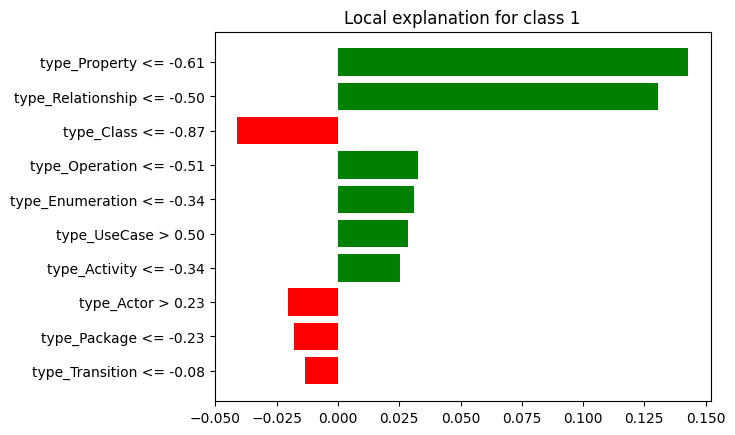

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_rf_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['type_UseCase', 'type_Relationship', 'type_Property', 'type_Actor', 'type_Operation', 'type_Class', 'type_Activity', 'type_Enumeration', 'type_DataType', 'type_Package']
['type_Relationship', 'type_UseCase', 'type_Property', 'type_Operation', 'type_Activity', 'type_Class', 'type_Actor', 'type_Enumeration', 'type_Component', 'type_Package']
['type_Property', 'type_Relationship', 'type_Class', 'type_Operation', 'type_Enumeration', 'type_UseCase', 'type_Activity', 'type_Actor', 'type_Package', 'type_Transition']
['type_Actor', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0       type_UseCase        1  Positive
1  type_Relationship        2  Positive
2      type_Property        3  Positive
3         type_Actor        4  Positive
4     type_Operation        5

In [ ]:
df_final_rf_fp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_UseCase              1  Positive       2  Positive       6  Positive
type_Relationship         2  Positive       1  Positive       2  Positive
type_Property             3  Positive       3  Positive       1  Positive
type_Actor                4  Positive       7  Positive       8  Negative
type_Operation            5  Positive       4  Positive       4  Positive
type_Class                6  Positive       6  Positive       3  Negative
type_Activity             7  Positive       5  Positive       7  Positive
type_Enumeration          8  Positive       8  Positive       5  Positive
type_DataType             9  Negative       -         -       -         -
type_Package             10  Negative      10  Negative       9  Negative
type_Component            -         -       9  Positive       -         -
type_Transition           -         -       -         -      10  Negative

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

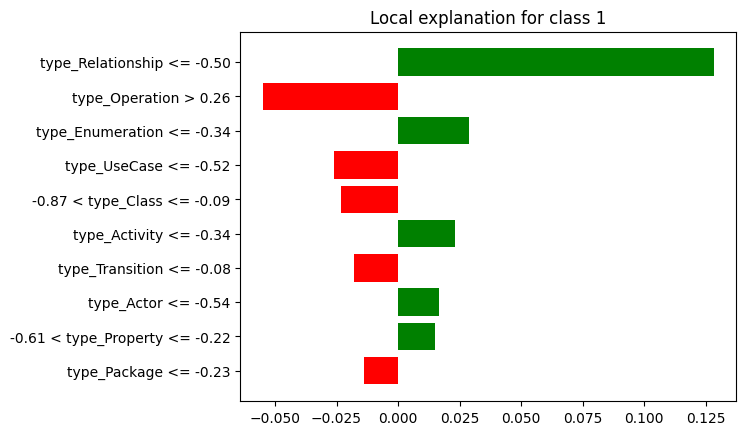

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_rf_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['type_Operation', 'type_Relationship', 'type_Class', 'type_UseCase', 'type_Activity', 'type_Property', 'type_Package', 'type_Enumeration', 'type_Actor', 'type_Component']
['type_Class', 'type_Operation', 'type_Relationship', 'type_UseCase', 'type_Property', 'type_Activity', 'type_Actor', 'type_Enumeration', 'type_Component', 'type_Package']
['type_Relationship', 'type_Operation', 'type_Enumeration', 'type_UseCase', 'type_Class', 'type_Activity', 'type_Transition', 'type_Actor', 'type_Property', 'type_Package']
['type_Actor', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0     type_Operation        1  Negative
1  type_Relationship        2  Positive
2         type_Class        3  Negative
3       type_UseCase        4  Negative
4      type_Activity        5  Positive
5    

In [ ]:
df_final_rf_fn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Operation            1  Negative       2  Negative       2  Negative
type_Relationship         2  Positive       3  Positive       1  Positive
type_Class                3  Negative       1  Negative       5  Negative
type_UseCase              4  Negative       4  Negative       4  Negative
type_Activity             5  Positive       6  Positive       6  Positive
type_Property             6  Positive       5  Positive       9  Positive
type_Package              7  Positive      10  Positive      10  Negative
type_Enumeration          8  Positive       8  Positive       3  Positive
type_Actor                9  Negative       7  Positive       8  Positive
type_Component           10  Negative       9  Negative       -         -
type_Transition           -         -       -         -       7  Negative

### Results RF:

In [ ]:
df_topfeatures_tp_rf = top5_features(df_final_rf_tp, 'TP')
df_topfeatures_tn_rf = top5_features(df_final_rf_tn, 'TN')
df_topfeatures_fp_rf = top5_features(df_final_rf_fp, 'FP')
df_topfeatures_fn_rf = top5_features(df_final_rf_fn, 'FN')

df_topfeatures_rf = pd.concat([df_topfeatures_tp_rf, df_topfeatures_tn_rf, df_topfeatures_fp_rf, df_topfeatures_fn_rf])
df_topfeatures_rf

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Activity, type_Class, type_Property, type...","type_Class, type_Property, type_Relationship, ...","type_Activity, type_Enumeration, type_Class, t...",0.8,0.6,0.4
TN,"type_Activity, type_UseCase, type_Property, ty...","type_UseCase, type_Property, type_Relationship...","type_UseCase, type_Property, type_Class, type_...",0.8,0.6,0.8
FP,"type_UseCase, type_Property, type_Relationship...","type_Activity, type_UseCase, type_Property, ty...","type_Enumeration, type_Class, type_Property, t...",0.8,0.6,0.6
FN,"type_Activity, type_UseCase, type_Class, type_...","type_UseCase, type_Property, type_Class, type_...","type_Enumeration, type_UseCase, type_Class, ty...",0.8,0.8,0.8


In [ ]:
df_topfeatures_tp_rank_rf = top5_rank(df_final_rf_tp, 'TP')
df_topfeatures_tn_rank_rf = top5_rank(df_final_rf_tn, 'TN')
df_topfeatures_fp_rank_rf = top5_rank(df_final_rf_fp, 'FP')
df_topfeatures_fn_rank_rf = top5_rank(df_final_rf_fn, 'FN')

df_topfeatures_rank_rf = pd.concat([df_topfeatures_tp_rank_rf, df_topfeatures_tn_rank_rf, df_topfeatures_fp_rank_rf, df_topfeatures_fn_rank_rf])
df_topfeatures_rank_rf

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Class, 2:type_Property, 3:type_Relation...","1:type_Class, 2:type_Property, 4:type_Relation...","1:type_Class, 5:type_Actor, 3:type_Activity, 4...",0.4,0.2,0.4
TN,"1:type_Actor, 2:type_UseCase, 3:type_Relations...","2:type_Actor, 4:type_UseCase, 3:type_Relations...","4:type_UseCase, 2:type_Relationship, 1:type_Pr...",0.2,0.0,0.6
FP,"1:type_UseCase, 2:type_Relationship, 3:type_Pr...","2:type_UseCase, 1:type_Relationship, 3:type_Pr...","2:type_Relationship, 1:type_Property, 4:type_O...",0.2,0.2,0.2
FN,"1:type_Operation, 2:type_Relationship, 3:type_...","2:type_Operation, 3:type_Relationship, 1:type_...","2:type_Operation, 1:type_Relationship, 5:type_...",0.2,0.2,0.4


In [ ]:
df_topfeatures_tp_sign_rf = top5_sign(df_final_rf_tp, 'TP')
df_topfeatures_tn_sign_rf = top5_sign(df_final_rf_tn, 'TN')
df_topfeatures_fp_sign_rf = top5_sign(df_final_rf_fp, 'FP')
df_topfeatures_fn_sign_rf = top5_sign(df_final_rf_fn, 'FN')

df_topfeatures_sign_rf = pd.concat([df_topfeatures_tp_sign_rf, df_topfeatures_tn_sign_rf, df_topfeatures_fp_sign_rf, df_topfeatures_fn_sign_rf])
df_topfeatures_sign_rf

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Class:Positive, type_Property:Positive, t...","type_Class:Positive, type_Property:Positive, t...","type_Class:Positive, type_Actor:Positive, type...",0.8,0.6,0.4
TN,"type_Actor:Negative, type_UseCase:Positive, ty...","type_Actor:Negative, type_UseCase:Positive, ty...","type_UseCase:Positive, type_Relationship:Negat...",0.8,0.6,0.8
FP,"type_UseCase:Positive, type_Relationship:Posit...","type_UseCase:Positive, type_Relationship:Posit...","type_Relationship:Positive, type_Property:Posi...",0.8,0.6,0.6
FN,"type_Operation:Negative, type_Relationship:Pos...","type_Operation:Negative, type_Relationship:Pos...","type_Operation:Negative, type_Relationship:Pos...",0.8,0.8,0.8


In [ ]:
df_topfeatures_tp_rank_sign_rf = top5_rank_sign(df_final_rf_tp, 'TP')
df_topfeatures_tn_rank_sign_rf = top5_rank_sign(df_final_rf_tn, 'TN')
df_topfeatures_fp_rank_sign_rf = top5_rank_sign(df_final_rf_fp, 'FP')
df_topfeatures_fn_rank_sign_rf = top5_rank_sign(df_final_rf_fn, 'FN')

df_topfeatures_rank_sign_rf = pd.concat([df_topfeatures_tp_rank_sign_rf, df_topfeatures_tn_rank_sign_rf, df_topfeatures_fp_rank_sign_rf, df_topfeatures_fn_rank_sign_rf])
df_topfeatures_rank_sign_rf

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Class:Positive, 2:type_Property:Positiv...","1:type_Class:Positive, 2:type_Property:Positiv...","1:type_Class:Positive, 5:type_Actor:Positive, ...",0.4,0.2,0.4
TN,"1:type_Actor:Negative, 2:type_UseCase:Positive...","2:type_Actor:Negative, 4:type_UseCase:Positive...","4:type_UseCase:Positive, 2:type_Relationship:N...",0.2,0.0,0.6
FP,"1:type_UseCase:Positive, 2:type_Relationship:P...","2:type_UseCase:Positive, 1:type_Relationship:P...","2:type_Relationship:Positive, 1:type_Property:...",0.2,0.2,0.2
FN,"1:type_Operation:Negative, 2:type_Relationship...","2:type_Operation:Negative, 3:type_Relationship...","2:type_Operation:Negative, 1:type_Relationship...",0.2,0.2,0.4


## KNN:

In [ ]:
exp = dx.Explainer(model_knn, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 3584 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3584 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7a781727ea70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.14, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.5, mean = -0.0221, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
instance_tp = X_test.loc[inst_tp_knn]
instance_tn = X_test.loc[inst_tn_knn]
instance_fp = X_test.loc[inst_fp_knn]
instance_fn = X_test.loc[inst_fn_knn]

In [ ]:
breakdown_tp = exp.predict_parts(instance_tp, type="break_down",random_state=42)
shap_tp = exp.predict_parts(instance_tp, type="shap",random_state=42)
lime_tp = exp.predict_surrogate(instance_tp, random_state=42)

breakdown_tn = exp.predict_parts(instance_tn, type="break_down",random_state=42)
shap_tn = exp.predict_parts(instance_tn, type="shap",random_state=42)
lime_tn = exp.predict_surrogate(instance_tn, random_state=42)

breakdown_fp = exp.predict_parts(instance_fp, type="break_down",random_state=42)
shap_fp = exp.predict_parts(instance_fp, type="shap",random_state=42)
lime_fp = exp.predict_surrogate(instance_fp, random_state=42)

breakdown_fn = exp.predict_parts(instance_fn, type="break_down",random_state=42)
shap_fn = exp.predict_parts(instance_fn, type="shap",random_state=42)
lime_fn = exp.predict_surrogate(instance_fn, random_state=42)

### TP:

In [ ]:
breakdown_df_tp = breakdown_tp.result
shap_df_tp = shap_tp.result
lime_df_tp = lime_tp.result

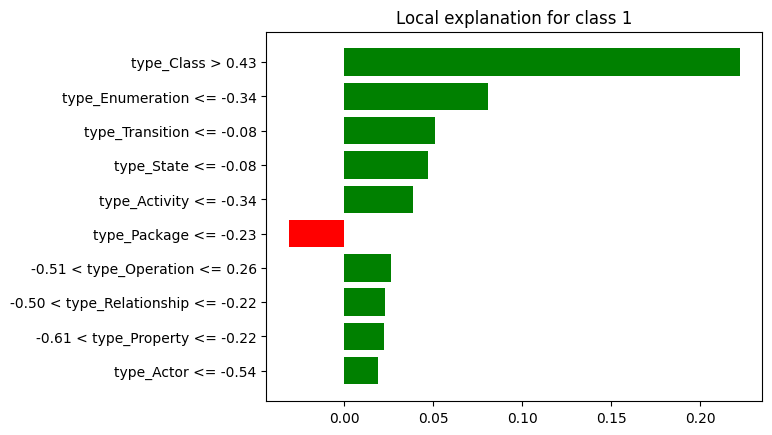

In [ ]:
breakdown_tp.plot()
shap_tp.plot()
lime_tp.plot()

In [ ]:
breakdown_df_tp, shap_df_tp, lime_df_tp, df_final_knn_tp = preprocess_dfs(breakdown_df_tp, shap_df_tp, lime_df_tp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tp)
print('----------------------------------------------')
print(shap_df_tp)
print('----------------------------------------------')
print(lime_df_tp)

['type_Class', 'type_Operation', 'type_Actor', 'type_Enumeration', 'type_Property', 'type_UseCase', 'type_DataType', 'type_Activity', 'type_Component', 'type_Transition']
['type_Class', 'type_Operation', 'type_Property', 'type_Enumeration', 'type_Actor', 'type_Activity', 'type_UseCase', 'type_Component', 'type_DataType', 'type_Relationship']
['type_Class', 'type_Enumeration', 'type_Transition', 'type_State', 'type_Activity', 'type_Package', 'type_Operation', 'type_Relationship', 'type_Property', 'type_Actor']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Activity', 'type_Enumeration', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
            Feature  Ranking      Sign
0        type_Class        1  Positive
1    type_Operation        2  Positive
2        type_Actor        3  Positive
3  type_Enumeration        4  Positive
4     type_Property  

In [ ]:
df_final_knn_tp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Class                1  Positive       1  Positive       1  Positive
type_Operation            2  Positive       2  Positive       7  Positive
type_Actor                3  Positive       5  Positive      10  Positive
type_Enumeration          4  Positive       4  Positive       2  Positive
type_Property             5  Positive       3  Positive       9  Positive
type_UseCase              6  Positive       7  Positive       -         -
type_DataType             7  Positive       9  Positive       -         -
type_Activity             8  Positive       6  Positive       5  Positive
type_Component            9  Positive       8  Positive       -         -
type_Transition          10  Positive       -         -       3  Positive
type_Relationship         -         -      10  Positive       8  Positive
type_State                -         -       -         -       4  Positive
type_Package              -         -       -         -       6  Negative

### TN:

In [ ]:
breakdown_df_tn = breakdown_tn.result
shap_df_tn = shap_tn.result
lime_df_tn = lime_tn.result

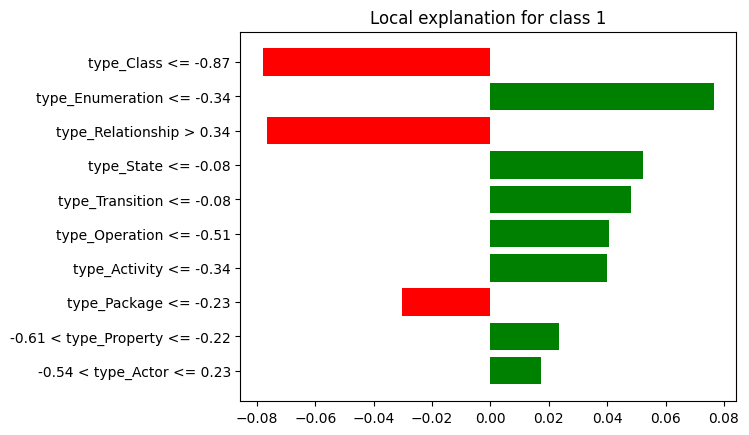

In [ ]:
breakdown_tn.plot()
shap_tn.plot()
lime_tn.plot()

In [ ]:
breakdown_df_tn, shap_df_tn, lime_df_tn, df_final_knn_tn = preprocess_dfs(breakdown_df_tn, shap_df_tn, lime_df_tn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_tn)
print('----------------------------------------------')
print(shap_df_tn)
print('----------------------------------------------')
print(lime_df_tn)

['type_Relationship', 'type_Property', 'type_Activity', 'type_Operation', 'type_Actor', 'type_Package', 'type_UseCase', 'type_DataType', 'type_Enumeration', 'type_Component']
['type_Relationship', 'type_Actor', 'type_Operation', 'type_UseCase', 'type_Class', 'type_Activity', 'type_Property', 'type_Enumeration', 'type_Package', 'type_DataType']
['type_Class', 'type_Enumeration', 'type_Relationship', 'type_State', 'type_Transition', 'type_Operation', 'type_Activity', 'type_Package', 'type_Property', 'type_Actor']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0  type_Relationship        1  Negative
1      type_Property        2  Positive
2      type_Activity        3  Positive
3     type_Operation        4  Positive
4         type

In [ ]:
df_final_knn_tn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Relationship         1  Negative       1  Negative       3  Negative
type_Property             2  Positive       7  Negative       9  Positive
type_Activity             3  Positive       6  Positive       7  Positive
type_Operation            4  Positive       3  Positive       6  Positive
type_Actor                5  Negative       2  Negative      10  Positive
type_Package              6  Positive       9  Positive       8  Negative
type_UseCase              7  Positive       4  Negative       -         -
type_DataType             8  Positive      10  Positive       -         -
type_Enumeration          9  Positive       8  Positive       2  Positive
type_Component           10  Positive       -         -       -         -
type_Class                -         -       5  Negative       1  Negative
type_State                -         -       -         -       4  Positive
type_Transition           -         -       -         -       5  Positive

### FP:

In [ ]:
breakdown_df_fp = breakdown_fp.result
shap_df_fp = shap_fp.result
lime_df_fp = lime_fp.result

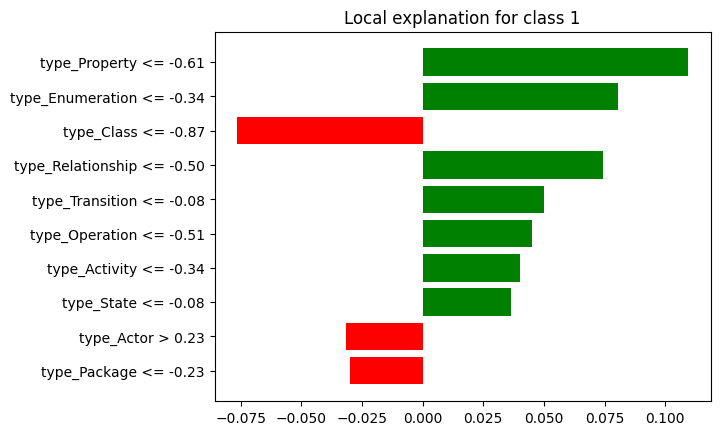

In [ ]:
breakdown_fp.plot()
shap_fp.plot()
lime_fp.plot()

In [ ]:
breakdown_df_fp, shap_df_fp, lime_df_fp, df_final_knn_fp = preprocess_dfs(breakdown_df_fp, shap_df_fp, lime_df_fp, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fp)
print('----------------------------------------------')
print(shap_df_fp)
print('----------------------------------------------')
print(lime_df_fp)

['type_Actor', 'type_Property', 'type_Relationship', 'type_Activity', 'type_Operation', 'type_Component', 'type_DataType', 'type_Package', 'type_Enumeration', 'type_UseCase']
['type_Property', 'type_UseCase', 'type_Actor', 'type_Relationship', 'type_Activity', 'type_Component', 'type_Operation', 'type_Package', 'type_Class', 'type_Enumeration']
['type_Property', 'type_Enumeration', 'type_Class', 'type_Relationship', 'type_Transition', 'type_Operation', 'type_Activity', 'type_State', 'type_Actor', 'type_Package']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0         type_Actor        1  Positive
1      type_Property        2  Positive
2  type_Relationship        3  Positive
3      type_Activity        4  Positive
4     type_Op

In [ ]:
df_final_knn_fp

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_Actor                1  Positive       3  Positive       9  Negative
type_Property             2  Positive       1  Positive       1  Positive
type_Relationship         3  Positive       4  Positive       4  Positive
type_Activity             4  Positive       5  Positive       7  Positive
type_Operation            5  Positive       7  Positive       6  Positive
type_Component            6  Positive       6  Positive       -         -
type_DataType             7  Positive       -         -       -         -
type_Package              8  Positive       8  Positive      10  Negative
type_Enumeration          9  Positive      10  Positive       2  Positive
type_UseCase             10  Positive       2  Positive       -         -
type_Class                -         -       9  Positive       3  Negative
type_State                -         -       -         -       8  Positive
type_Transition           -         -       -         -       5  Positive

### FN:

In [ ]:
breakdown_df_fn = breakdown_fn.result
shap_df_fn = shap_fn.result
lime_df_fn = lime_fn.result

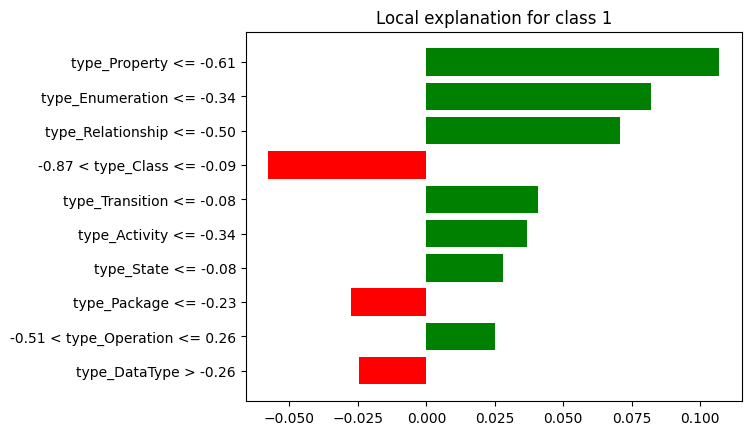

In [ ]:
breakdown_fn.plot()
shap_fn.plot()
lime_fn.plot()

In [ ]:
breakdown_df_fn, shap_df_fn, lime_df_fn, df_final_knn_fn = preprocess_dfs(breakdown_df_fn, shap_df_fn, lime_df_fn, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_fn)
print('----------------------------------------------')
print(shap_df_fn)
print('----------------------------------------------')
print(lime_df_fn)

['type_DataType', 'type_Property', 'type_Relationship', 'type_Operation', 'type_UseCase', 'type_Activity', 'type_Component', 'type_Enumeration', 'type_Actor', 'type_Package']
['type_DataType', 'type_Class', 'type_Property', 'type_Relationship', 'type_Operation', 'type_Package', 'type_Enumeration', 'type_UseCase', 'type_Component', 'type_Activity']
['type_Property', 'type_Enumeration', 'type_Relationship', 'type_Class', 'type_Transition', 'type_Activity', 'type_State', 'type_Package', 'type_Operation', 'type_DataType']
['type_Actor', 'type_State', 'type_Transition', 'type_UseCase', 'type_Class', 'type_Operation', 'type_DataType', 'type_Property', 'type_Enumeration', 'type_Activity', 'type_Component', 'type_Package', 'type_Relationship']
----------------------------------------------
             Feature  Ranking      Sign
0      type_DataType        1  Negative
1      type_Property        2  Positive
2  type_Relationship        3  Negative
3     type_Operation        4  Positive
4      

In [ ]:
df_final_knn_fn

Breakdown              Shap              Lime          
                    Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                                  
type_DataType             1  Negative       1  Negative      10  Negative
type_Property             2  Positive       3  Positive       1  Positive
type_Relationship         3  Negative       4  Positive       3  Positive
type_Operation            4  Positive       5  Positive       9  Positive
type_UseCase              5  Positive       8  Negative       -         -
type_Activity             6  Positive      10  Positive       6  Positive
type_Component            7  Positive       9  Negative       -         -
type_Enumeration          8  Positive       7  Negative       2  Positive
type_Actor                9  Positive       -         -       -         -
type_Package             10  Positive       6  Negative       8  Negative
type_Class                -         -       2  Negative       4  Negative
type_State                -         -       -         -       7  Positive
type_Transition           -         -       -         -       5  Positive

### Results KNN:

In [ ]:
df_topfeatures_tp_knn = top5_features(df_final_knn_tp, 'TP')
df_topfeatures_tn_knn = top5_features(df_final_knn_tn, 'TN')
df_topfeatures_fp_knn = top5_features(df_final_knn_fp, 'FP')
df_topfeatures_fn_knn = top5_features(df_final_knn_fn, 'FN')

df_topfeatures_knn = pd.concat([df_topfeatures_tp_knn, df_topfeatures_tn_knn, df_topfeatures_fp_knn, df_topfeatures_fn_knn])
df_topfeatures_knn

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Enumeration, type_Class, type_Property, t...","type_Enumeration, type_Class, type_Property, t...","type_Activity, type_Enumeration, type_Class, t...",1.0,0.4,0.4
TN,"type_Activity, type_Property, type_Relationshi...","type_UseCase, type_Class, type_Relationship, t...","type_Enumeration, type_Class, type_Transition,...",0.6,0.2,0.4
FP,"type_Activity, type_Property, type_Relationshi...","type_Activity, type_UseCase, type_Property, ty...","type_Enumeration, type_Class, type_Property, t...",0.8,0.4,0.4
FN,"type_DataType, type_UseCase, type_Property, ty...","type_DataType, type_Class, type_Property, type...","type_Enumeration, type_Class, type_Property, t...",0.8,0.4,0.6


In [ ]:
df_topfeatures_tp_rank_knn = top5_rank(df_final_knn_tp, 'TP')
df_topfeatures_tn_rank_knn = top5_rank(df_final_knn_tn, 'TN')
df_topfeatures_fp_rank_knn = top5_rank(df_final_knn_fp, 'FP')
df_topfeatures_fn_rank_knn = top5_rank(df_final_knn_fn, 'FN')

df_topfeatures_rank_knn = pd.concat([df_topfeatures_tp_rank_knn, df_topfeatures_tn_rank_knn, df_topfeatures_fp_rank_knn, df_topfeatures_fn_rank_knn])
df_topfeatures_rank_knn

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Class, 2:type_Operation, 3:type_Actor, ...","1:type_Class, 2:type_Operation, 5:type_Actor, ...","1:type_Class, 2:type_Enumeration, 5:type_Activ...",0.6,0.2,0.2
TN,"1:type_Relationship, 2:type_Property, 3:type_A...","1:type_Relationship, 3:type_Operation, 2:type_...","3:type_Relationship, 2:type_Enumeration, 1:typ...",0.2,0.0,0.0
FP,"1:type_Actor, 2:type_Property, 3:type_Relation...","3:type_Actor, 1:type_Property, 4:type_Relation...","1:type_Property, 4:type_Relationship, 2:type_E...",0.0,0.0,0.4
FN,"1:type_DataType, 2:type_Property, 3:type_Relat...","1:type_DataType, 3:type_Property, 4:type_Relat...","1:type_Property, 3:type_Relationship, 2:type_E...",0.2,0.2,0.0


In [ ]:
df_topfeatures_tp_sign_knn = top5_sign(df_final_knn_tp, 'TP')
df_topfeatures_tn_sign_knn = top5_sign(df_final_knn_tn, 'TN')
df_topfeatures_fp_sign_knn = top5_sign(df_final_knn_fp, 'FP')
df_topfeatures_fn_sign_knn = top5_sign(df_final_knn_fn, 'FN')

df_topfeatures_sign_knn = pd.concat([df_topfeatures_tp_sign_knn, df_topfeatures_tn_sign_knn, df_topfeatures_fp_sign_knn, df_topfeatures_fn_sign_knn])
df_topfeatures_sign_knn

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"type_Class:Positive, type_Operation:Positive, ...","type_Class:Positive, type_Operation:Positive, ...","type_Class:Positive, type_Enumeration:Positive...",1.0,0.4,0.4
TN,"type_Relationship:Negative, type_Property:Posi...","type_Relationship:Negative, type_Operation:Pos...","type_Relationship:Negative, type_Enumeration:P...",0.6,0.2,0.4
FP,"type_Actor:Positive, type_Property:Positive, t...","type_Actor:Positive, type_Property:Positive, t...","type_Property:Positive, type_Relationship:Posi...",0.8,0.4,0.4
FN,"type_DataType:Negative, type_Property:Positive...","type_DataType:Negative, type_Property:Positive...","type_Property:Positive, type_Relationship:Posi...",0.6,0.2,0.6


In [ ]:
df_topfeatures_tp_rank_sign_knn = top5_rank_sign(df_final_knn_tp, 'TP')
df_topfeatures_tn_rank_sign_knn = top5_rank_sign(df_final_knn_tn, 'TN')
df_topfeatures_fp_rank_sign_knn = top5_rank_sign(df_final_knn_fp, 'FP')
df_topfeatures_fn_rank_sign_knn = top5_rank_sign(df_final_knn_fn, 'FN')

df_topfeatures_rank_sign_knn = pd.concat([df_topfeatures_tp_rank_sign_knn, df_topfeatures_tn_rank_sign_knn, df_topfeatures_fp_rank_sign_knn, df_topfeatures_fn_rank_sign_knn])
df_topfeatures_rank_sign_knn

,TOP5 Breakdown,TOP5 Shap,TOP5 Lime,Breakdown-Shap,Breakdown-Lime,Lime-Shap
TP,"1:type_Class:Positive, 2:type_Operation:Positi...","1:type_Class:Positive, 2:type_Operation:Positi...","1:type_Class:Positive, 2:type_Enumeration:Posi...",0.6,0.2,0.2
TN,"1:type_Relationship:Negative, 2:type_Property:...","1:type_Relationship:Negative, 3:type_Operation...","3:type_Relationship:Negative, 2:type_Enumerati...",0.2,0.0,0.0
FP,"1:type_Actor:Positive, 2:type_Property:Positiv...","3:type_Actor:Positive, 1:type_Property:Positiv...","1:type_Property:Positive, 4:type_Relationship:...",0.0,0.0,0.4
FN,"1:type_DataType:Negative, 2:type_Property:Posi...","1:type_DataType:Negative, 3:type_Property:Posi...","1:type_Property:Positive, 3:type_Relationship:...",0.2,0.0,0.0
